# **1. Crop the cells from image**

Read the input gridded input and crop out the cells and store into an array


***Imports***

In [ ]:
# !pip install pandas tabulate
# !pip install seaborn

# Import libraries
import cv2
import os
import sys
import shutil
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from sklearn.utils import shuffle
from keras.optimizers import Adam
from skimage.filters import sobel
from keras.layers import MaxPool2D
from keras.models import Sequential
from keras.utils import to_categorical
from skimage.segmentation import watershed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab.patches import cv2_imshow

In [ ]:
# Define colours
red = (0, 0, 255)
black = (0, 0, 0)
white = (255, 255, 255)
blue = (255, 0, 0)
green = (0, 255, 0)
yellow = (0, 255, 255)
orange = (0, 165, 255)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

source_path = '/content/drive/My Drive/Major Project/new_dataset/Dataset'
destination_path = '/content/Dataset'

# Copy the entire directory to a new location
shutil.copytree(source_path, destination_path)

print(f"Folder copied from {source_path} to {destination_path}")

# List all files and directories in the new location
print("Contents of the copied folder:")
for item in os.listdir(destination_path):
    print(item)



Folder copied from /content/drive/MyDrive/Dataset to /content/Dataset
Contents of the copied folder:
Test
Train


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the folder to store cropped images
output_folder = "cropped_images"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to process and save cropped images from a single image
def process_image(image_path, output_folder):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply edge detection using Canny
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize an empty list to store cropped images
    cropped_images = []

    # Define additional filters for valid cells
    min_area = 1000  # Minimum area for a valid cell
    max_aspect_ratio = 2.5  # Maximum aspect ratio for a valid cell
    crop_offset = 10

    # Create a folder to store the cropped images for this image
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    image_folder = os.path.join(output_folder, image_name)
    os.makedirs(image_folder, exist_ok=True)

    # Loop through all contours and filter based on area and aspect ratio
    for i, contour in enumerate(contours):
        # print("i : ", i)
        j=len(cropped_images)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if cv2.contourArea(contour) < min_area or aspect_ratio > max_aspect_ratio:
            continue

        # Crop the region of interest (ROI) from the original image
        cropped_image = img[y+crop_offset:y+h-(crop_offset), x+crop_offset:x+w-(crop_offset)]

        # Convert to grayscale if needed
        updated_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

        # Save the cropped image with a unique filename
        output_filename = os.path.join(image_folder, f"cell_{j+1}.jpg")
        cv2.imwrite(output_filename, cropped_image)

        # Append the cropped image to the list
        cropped_images.append(updated_image)

        if len(cropped_images) == 21:
            break

    return cropped_images, image_name

# Traverse the Train directory and process each image
train_folder = "/content/Dataset/Test"
for subdir, dirs, files in os.walk(train_folder):
    for file in files:
        image_path = os.path.join(subdir, file)
        cropped_images, image_name = process_image(image_path, output_folder)


        # # # Display all cropped images
        # n_rows = 5
        # n_cols = 5

        # plt.figure(figsize=(15, 10))
        # for i, image in enumerate(cropped_images):
        #     plt.subplot(n_rows, n_cols, i + 1)
        #     plt.imshow(image, cmap='gray')
        #     plt.title(f'Cell {i + 1}')
        #     plt.axis('off')

        # plt.suptitle(f"Image: {image_name}")
        # plt.tight_layout()
        # plt.show()

print("Images cropped and saved successfully.")


Images cropped and saved successfully.


### Create a local copy of the croppped images

In [ ]:
import shutil
from google.colab import files

# Compress the folder into a zip file
shutil.make_archive('/content/cropped_images', 'zip', '/content/cropped_images')

# Download the zip file
files.download('/content/cropped_images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import os

# def list_directory_contents(path):
#     num_images = 0
#     for item in os.listdir(path):
#         item_path = os.path.join(path, item)
#         if os.path.isfile(item_path):
#             print(f"File: {item_path}")
#             if item.endswith('.jpg'):
#                 num_images += 1
#         elif os.path.isdir(item_path):
#             print(f"Directory: {item_path}")
#             num_images_in_subdir = list_directory_contents(item_path)  # Recursively list contents of subdirectory
#             num_images += num_images_in_subdir
#     print(f"Total number of images in {path}: {num_images}")
#     return num_images

# # Specify the path to the directory you want to list
# directory_path = "/content/cropped_images"

# # Call the function to list contents
# list_directory_contents(directory_path)


In [ ]:
# !rm -r "/content/cropped_images" "/content/pre_processed_images" "/content/sample_data" "/content/output_images" "/content/pp_images"

# ***2. Read the image and start pre-processing***

***Show the pre-processing steps's output***

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage.segmentation import watershed

# Function to process and save pre-processed images from a single cropped image
def process_image(image_path,output_path):
    # Read the cropped image
    img = cv2.imread(image_path)
    # print("in :" , image_path)

    # Create the output folder dynamically based on the image name
    output_folder = os.path.join(output_path, os.path.splitext(os.path.basename(image_path))[0])
    # print("out 2 :" , output_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    ################## Pre-processing #####################
    # print("1-Converting image to grayscale")
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # print("2-Applying blur")
    gaussian_blur = cv2.GaussianBlur(gray,(3,3),0)

    # print("3-Applying threshold")
    _,thresh_otsu = cv2.threshold(gaussian_blur,127,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # print("4-Applying elevation map")
    elevation_map_otsu_blur = sobel(thresh_otsu)

    # print("5-Applying segmentation")
    markers = np.zeros_like(thresh_otsu)
    markers[thresh_otsu < 30] = 1
    markers[thresh_otsu > 150] = 2
    segmentation_otsu_blur = watershed(elevation_map_otsu_blur, markers)
    segmentation_normalised = cv2.normalize(src=segmentation_otsu_blur, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    ### Show image processed from original to final
    titles = ['Original Image', 'Gray', 'Gaussian Blur', 'Threshhold','Elevation Map', 'Segmentation']
    images = [img, gray, gaussian_blur, thresh_otsu, elevation_map_otsu_blur, segmentation_normalised]
    inputCopy = img

    ### Save the pre-processed images with specified names ###
    cell_name = os.path.splitext(os.path.basename(image_path))[0]  # Get the cell name from the image filename

    # Normalize the pixel values to the range [0, 255]
    normalized_images = []
    for image in images:
        normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        normalized_images.append(normalized_image)

    # Specify the names for the pre-processed images
    ppimages = {
        'Original_Image': normalized_images[0],
        'Gray': normalized_images[1],
        'Gaussian_Blur': normalized_images[2],
        'Threshhold': normalized_images[3],
        'Elevation_Map': normalized_images[4],
        'Segmentation': normalized_images[5]
    }

    # Save each pre-processed image with the specified name format
    for name, image in ppimages.items():
        output_filename = os.path.join(output_folder, f"{name}_{cell_name}.jpg")
        cv2.imwrite(output_filename, image)


    # plt.figure(figsize=(15, 10))
    # for i in np.arange(len(images)):
    #     plt.subplot(1,6, i + 1)
    #     plt.imshow(images[i], 'gray')
    #     plt.title(titles[i])
    #     plt.xticks([]), plt.yticks([])

    # # Adjust the height between subplots to reduce the gap
    # # plt.subplots_adjust(hspace=-0.01)
    # # plt.show()

    # Save the pre-processed image
    output_filename = os.path.join(output_folder, os.path.basename(image_path))
    # print("output_filename : ", output_filename)
    cv2.imwrite(output_filename, segmentation_otsu_blur)

# Traverse the cropped_images directory and process each image
cropped_images_folder = "/content/cropped_images"
for subdir, dirs, files in os.walk(cropped_images_folder):
    print("subdir : ", subdir)
    print("dirs : ", dirs)
    print("files : ", files)

    output_folder = os.path.join("pp_images", os.path.splitext(os.path.basename(subdir))[0])
    # print("out 1 :" , output_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    print("\n############################################### Pre-processing starts ###############################################   \n")
    for file in files:
        image_path = os.path.join(subdir, file)
        process_image(image_path,output_folder)
    print("\n################################################ Pre-processing is Done! ###########################################    \n\n\n\n")


print("Images pre-processed and saved successfully.")


In [ ]:
def list_directory_contents(path):
    num_images = 0
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isfile(item_path):
            print(f"File: {item_path}")
            if item.endswith('.jpg'):
                num_images += 1
        elif os.path.isdir(item_path):
            print(f"Directory: {item_path}")
            num_images_in_subdir = list_directory_contents(item_path)  # Recursively list contents of subdirectory
            num_images += num_images_in_subdir
    print(f"Total number of images in {path}: {num_images}")
    return num_images

# Specify the path to the directory you want to list
directory_path = "/content/pp_images"

# Call the function to list contents
list_directory_contents(directory_path)


# ***3. Start using Contour Detection***

In [ ]:
# Create original copies
inputCopy = cv2.imread("/content/pp_images/abhilash_l/cell_1/Original_Image_cell_1.jpg")
master_img_copy = inputCopy.copy()
bb_only_img = inputCopy.copy()
cc_only_img = inputCopy.copy()

In [ ]:
################# Crop Image #####################
# print("\nCropping image starts...")
#### Find countours from thresholded image
segmentation_normalised = cv2.imread("/content/pp_images/abhilash_l/cell_1/Segmentation_cell_1.jpg")
contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

#### Check for outer contours
contours_poly = [None] * len(contours)
boundRect = []
for i, c in enumerate(contours):
    if hierarchy[0][i][3] == -1:
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect.append(cv2.boundingRect(contours_poly[i]))


print("Original Bounding Boxes        : ", boundRect)
boundRect = sorted(boundRect)
print("Original Sorted Bounding Boxes : ", boundRect)

# Define a threshold for width and height
width_threshold = 10
height_threshold = 10

# Filter bounding boxes based on width and height
boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]
print("Filtered Bounding Boxes        : ", boundRect)

### Draw retangles around the letters in the copied image
for box in boundRect:
    x, y, width, height = box
    cv2.rectangle(inputCopy, (x, y), (x + width, y + height), blue , 1)
    cv2.rectangle(bb_only_img, (x, y), (x + width, y + height), blue , 1)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [ ]:
# Draw points along the outer boundary of filtered contours
for c in contours:
    # Draw the entire contour
    color1 = (0, 255, 0) #green
    color2 = (100,255,255)   #yellow
    cv2.drawContours(inputCopy, [c], 0, color1, 1)

    # Get points along the contour
    epsilon = 0.1 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)

    # Draw points on the inputCopy image
    point_size = 3
     # Adjust the point size as needed
    for point in approx:
        cv2.circle(inputCopy, tuple(point[0]), point_size, color2, -1)
        cv2.circle(cc_only_img, tuple(point[0]), point_size, color2, -1)

In [ ]:
### Show image processed from bb to cc
titles = ['Bounding Box Only', 'Contour Points Only','Bounding Box + Contour Edge + Contour Points']
images = [bb_only_img, cc_only_img, inputCopy]

plt.figure(figsize=(12, 5))
plt.subplots_adjust(hspace=0.5)

for i in np.arange(len(images)):
    plt.subplot(2,2, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()

***Display each individual cropped segment***

In [ ]:
# ### Crop the characteres from the image
# cropped_list = []
# for i in range(len(boundRect)):
#     #### Offset the image so is more in the center
#     dimension_offset = 5
#     position_offset = 2
#     x, y, w, h = boundRect[i]
#     h = h+dimension_offset
#     w = w+dimension_offset
#     x = x-position_offset
#     y = y-position_offset

#     #### Crop
#     croppedImg = segmentation_normalised[y:y + h, x:x + w]
#     cropped_list.append(croppedImg)
#     ### Show each character cropped
#     print("Cropped Character: "+str(i))
#     cv2_imshow( croppedImg)

# print("\nCropping is Done!")

Processing image: /content/pp_images/neetha_l/cell_20/Segmentation_cell_20.jpg


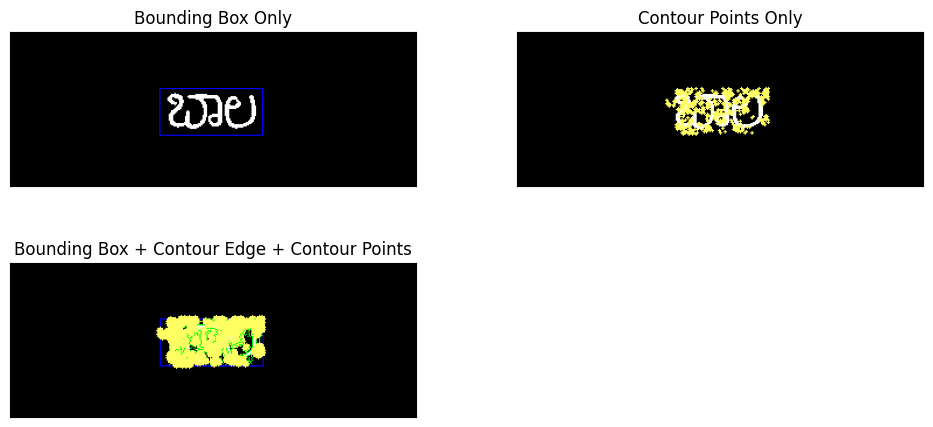

IndexError: list index out of range

In [ ]:
def process_image(image_path):
    # Load the image
    inputCopy = cv2.imread(image_path)
    master_img_copy = inputCopy.copy()
    bb_only_img = inputCopy.copy()
    cc_only_img = inputCopy.copy()

    # Read the Segmentation image
    segmentation_normalised = cv2.imread(image_path.replace("Original_Image", "Segmentation"), cv2.IMREAD_GRAYSCALE)

    # Find contours
    contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    contours_poly = [None] * len(contours)
    boundRect = []
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

    # Filter bounding boxes based on width and height
    width_threshold = 10
    height_threshold = 10
    boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]

    # Draw rectangles and contours
    for box in boundRect:
        x, y, width, height = box
        cv2.rectangle(inputCopy, (x, y), (x + width, y + height), (255, 0, 0), 1)
        cv2.rectangle(bb_only_img, (x, y), (x + width, y + height), (255, 0, 0), 1)

    for c in contours:
        cv2.drawContours(inputCopy, [c], 0, (0, 255, 0), 1)
        epsilon = 0.1 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        for point in approx:
            cv2.circle(inputCopy, tuple(point[0]), 3, (100, 255, 255), -1)
            cv2.circle(cc_only_img, tuple(point[0]), 1, (100, 255, 255), -10)

    # Display images
    titles = ['Bounding Box Only', 'Contour Points Only', 'Bounding Box + Contour Edge + Contour Points']
    images = [bb_only_img, cc_only_img, inputCopy]

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)

    for i in np.arange(len(images)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

    plt.show()

    # Extract features
    # Calculate word width and height - By using last and first bounding box's width and height
    word_width = boundRect[-1][0] - boundRect[0][0]
    word_height = boundRect[-1][1] - boundRect[0][1]

    # Calculate character widths and heights - By using bounding box's width and height data itself
    char_widths = [rect[2] for rect in boundRect]
    char_heights = [rect[3] for rect in boundRect]

    # Calculate character gaps for all characters by using difference between vertical last line of first character and first vertical bounding box line of second character
    char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i+1][0]) for i in range(len(boundRect)-1)]
    # Fill the first row of character gaps
    char_gaps = char_gaps + [char_gaps[-1]]

    # Calculate the skewed angle by plotting the most possible way of drawing a straight line that touches maximum top points from each character
    # Calculate the skewed angle
    # Assuming characters are aligned horizontally, find the angle that connects top points
    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)

    # Calculate the angle from the horizontal axis
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi
    char_widths = [rect[2] for rect in boundRect]
    char_heights = [rect[3] for rect in boundRect]
    char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i + 1][0]) for i in range(len(boundRect) - 1)]
    char_gaps += [char_gaps[-1]]

    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

    data = {'SI.No': list(range(len(boundRect))),
            'Character': [f'Char_{i + 1}' for i in range(len(boundRect))],
            'Bounding Box': boundRect,
            'Character Width': char_widths,
            'Character Height': char_heights,
            'Character Gaps': char_gaps,
            'Word Width': [word_width] * len(boundRect),
            'Word Height': [word_height] * len(boundRect),
            'Skewed Angle': [skewed_angle] * len(boundRect)}

    df = pd.DataFrame(data)

    print(" Feature Extraction Table :")
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

    print("\nBounding Boxes    : ", boundRect)
    print("Word Width        : ", word_width)
    print("Word Height       : ", word_height)
    print("Character Widths  : ", char_widths)
    print("Character Heights : ", char_heights)
    print("Character Gaps    : ", char_gaps)
    print("Skewed Angle      : ", skewed_angle)

    return inputCopy



# Process all images in the directory
directory = "/content/pp_images/neetha_l"
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("Segmentation"):
        # if file.startswith("Original"):
            image_path = os.path.join(root, file)
            print("Processing image:", image_path)
            processed_image = process_image(image_path)


In [ ]:
def process_image(image_path):
    # Load the image
    inputCopy = cv2.imread(image_path)
    master_img_copy = inputCopy.copy()
    bb_only_img = inputCopy.copy()
    cc_only_img = inputCopy.copy()

    # Read the Segmentation image
    segmentation_normalised = cv2.imread(image_path.replace("Original_Image", "Segmentation"), cv2.IMREAD_GRAYSCALE)

    # Find contours
    contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    contours_poly = [None] * len(contours)
    boundRect = []
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

    # Filter bounding boxes based on width and height
    width_threshold = 10
    height_threshold = 10
    boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]

    # Draw rectangles and contours
    for box in boundRect:
        x, y, width, height = box
        cv2.rectangle(inputCopy, (x, y), (x + width, y + height), (255, 0, 0), 1)
        cv2.rectangle(bb_only_img, (x, y), (x + width, y + height), (255, 0, 0), 1)

    for c in contours:
        cv2.drawContours(inputCopy, [c], 0, (0, 255, 0), 1)
        epsilon = 0.1 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        for point in approx:
            cv2.circle(inputCopy, tuple(point[0]), 3, (100, 255, 255), -1)
            cv2.circle(cc_only_img, tuple(point[0]), 3, (100, 255, 255), -1)

    # Display images
    titles = ['Bounding Box Only', 'Contour Points Only', 'Bounding Box + Contour Edge + Contour Points']
    images = [bb_only_img, cc_only_img, inputCopy]

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)

    for i in np.arange(len(images)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

    plt.show()

    # Extract features
    char_widths = [rect[2] for rect in boundRect]
    char_heights = [rect[3] for rect in boundRect]
    word_width = boundRect[-1][0] - boundRect[0][0]
    word_height = boundRect[-1][1] - boundRect[0][1]

    if len(boundRect) > 1:
        char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i + 1][0]) for i in range(len(boundRect) - 1)]
    else:
        # Append a default gap value if there is only one bounding box
        char_gaps = [10]

    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

    # Create DataFrame
    data = {'SI.No': list(range(len(boundRect))),
            'Character': [f'Char_{i + 1}' for i in range(len(boundRect))],
            'Bounding Box': boundRect,
            'Character Width': char_widths,
            'Character Height': char_heights,
            'Character Gaps': char_gaps,
            'Word Width': [word_width] * len(boundRect),
            'Word Height': [word_height] * len(boundRect),
            'Skewed Angle': [skewed_angle] * len(boundRect)}

    df = pd.DataFrame(data)

    print(" Feature Extraction Table :")
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

    print("\nBounding Boxes    : ", boundRect)
    print("Word Width        : ", word_width)
    print("Word Height       : ", word_height)
    print("Character Widths  : ", char_widths)
    print("Character Heights : ", char_heights)
    print("Character Gaps    : ", char_gaps)
    print("Skewed Angle      : ", skewed_angle)

    return inputCopy

# Process all images in the directory
directory = "/content/pp_images/arun_l"
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("Segmentation"):
        # if file.startswith("Original"):
            image_path = os.path.join(root, file)
            print("Processing image:", image_path)
            processed_image = process_image(image_path)


[link text](https://)# ***4. Extract Features***

***Identify top, left, right and bottom points from individual characters and draw a line based on first character's points***

In [ ]:
plt.imshow(cv2.cvtColor(inputCopy, cv2.COLOR_BGR2RGB))
cv2_imshow(inputCopy)

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load your image (replace 'your_image.jpg' with the actual path)
image = inputCopy

# Loop through the list of bounding boxes
print(len(boundRect))
bb_color = blue
for box in boundRect:
    x, y, width, height = box
    # Draw a rectangle on the image
    cv2.rectangle(image, (x, y), (x + width, y + height), bb_color , 1)

# Convert BGR image to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.imshow(image_rgb)
plt.title('Image with Bounding Boxes')
plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load your image (replace 'your_image.jpg' with the actual path)
# image = master_img_copy.copy()
image = inputCopy.copy()

# Get the values from the first bounding box
x1, y1, w1, h1 = boundRect[0]
l = int(1.5 * len(boundRect))

# # # Get the values from the bounding box with the lowest x value
# min_x_rect = min(boundRect, key=lambda rect: rect[0])
# x1, y1, w1, h1 = min_x_rect

# Calculate the starting and ending points for a horizontal line
start_point1 = (x1, y1)
end_point1 = (x1 + (w1*l), y1)

start_point2 = (x1, y1+h1)
end_point2 = (x1 + (w1*l), y1+h1)

# Draw a horizontal line on the image
cv2.line(image, start_point1, end_point1, red , 1)
cv2.line(image, start_point2, end_point2, red , 1)

# Convert BGR image to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with the horizontal line
plt.imshow(image_rgb)
plt.title('Image with Threshold Lines')
plt.show()

In [ ]:
# Calculate word width and height - By using last and first bounding box's width and height
word_width = boundRect[-1][0] - boundRect[0][0]
word_height = boundRect[-1][1] - boundRect[0][1]

# Calculate character widths and heights - By using bounding box's width and height data itself
char_widths = [rect[2] for rect in boundRect]
char_heights = [rect[3] for rect in boundRect]

# Calculate character gaps for all characters by using difference between vertical last line of first character and first vertical bounding box line of second character
char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i+1][0]) for i in range(len(boundRect)-1)]
# Fill the first row of character gaps
char_gaps = char_gaps + [char_gaps[-1]]

# Calculate the skewed angle by plotting the most possible way of drawing a straight line that touches maximum top points from each character
# Calculate the skewed angle
# Assuming characters are aligned horizontally, find the angle that connects top points
top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)

# Calculate the angle from the horizontal axis
skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

# Create a DataFrame for feature extraction
data = {'SI.No': list(range(len(boundRect))),
        'Character': [f'Char_{i+1}' for i in range(len(boundRect))],
        'Bounding Box': boundRect,
        'Character Width': char_widths,
        'Character Height': char_heights,
        'Character Gaps': char_gaps,
        'Word Width': [word_width] * len(boundRect),
        'Word Height': [word_height] * len(boundRect),
        'Skewed Angle': [skewed_angle] * len(boundRect)}

df = pd.DataFrame(data)

# Display the table
print(" Feature Extraction Table :")
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

# Print calculated values
print("\nBounding Boxes    : " , boundRect)
print("Word Width        : " , word_width)
print("Word Height       : " , word_height)
print("Character Widths  : " , char_widths)
print("Character Heights : " , char_heights)
print("Character Gaps    : " , char_gaps)
print("Skewed Angle      : " , skewed_angle)

In [ ]:
import cv2
import numpy as np
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Initialize a list to store the cropped characters
cropped_list = []

# Initialize a list to store the character labels
char_labels = []

for i in range(len(boundRect)):
    #### Offset the image so is more in the center
    dimension_offset = 5
    position_offset = 2
    x, y, w, h = boundRect[i]
    h = h+dimension_offset
    w = w+dimension_offset
    x = x-position_offset
    y = y-position_offset

    #### Crop
    cropped_character = segmentation_normalised[y:y + h, x:x + w]
    cropped_list.append(cropped_character)
    char_labels.append(f'Char_{i+1}')
    ### Show each character cropped
    print("Cropped Character: "+str(i))
    cv2_imshow( cropped_character)

    # # Display each cropped character
    # print("Cropped Character:", char_labels[-1])
    # plt.figure(figsize=(5, 5))
    # plt.title(char_labels[-1])
    # plt.imshow(cropped_character)
    # plt.show()

# Create a DataFrame for feature extraction
data = {'SI.No': list(range(len(boundRect))),
        'Character': char_labels,
        'Bounding Box': boundRect,
        'Width': [rect[2] for rect in boundRect],
        'Height': [rect[3] for rect in boundRect],
        'Word Width': [boundRect[-1][0] - boundRect[0][0]] * len(boundRect),
        'Word Height': [boundRect[-1][1] - boundRect[0][1]] * len(boundRect),
        'Character Gaps': [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i + 1][0]) for i in range(len(boundRect) - 1)] + [np.nan],
        'Skewed Angle': [np.nan] * len(boundRect)}

df = pd.DataFrame(data)

# # Display the image
# plt.imshow(inputCopy)
# plt.axis('off')  # Turn off axis for cleaner display

# Display the table using matplotlib's Table
# ax = plt.gca()
# ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='bottom', colColours=['#f5f5f5'] * df.shape[1])

plt.show()

# Display the table
print("Feature Extraction Table:")
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))


***Skew Angle : BB x and y approach and/or midpoints***

In [ ]:
# Load your image
image = bb_only_img.copy()
# image = inputCopy.copy()

topmost_points_color = red
ref_line_color = orange
skew_line_color = white
scaler = 150

# Calculate points for skewed angle calculation
top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
print(top_points)
top_points[0] = (64,50)
print(top_points)

# Fit a line to the points
vx, vy, x, y = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)

# Calculate the angle from the horizontal axis
skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

# Draw the selected points in black with stroke length of 2
for point in top_points:
    cv2.circle(image, (point[0], point[1]), 2, topmost_points_color, -1)

start_point = (int(x - vx * 100), int(y - vy * 100))
end_point = (int(x + vx * 100), int(y + vy * 100))
cv2.line(image, start_point, end_point, skew_line_color, 1)


# Draw the reference line (horizontal axis) in white
# ref_start_point = (int(x - vx * scaler), int(y - vy * scaler))
# ref_end_point = (int(x + vx * scaler), int(y + vy * scaler))

ref_start_point = (x1 - w1, y1)
ref_end_point = (x1 + (w1*l), y1)
cv2.line(image, ref_start_point, ref_end_point, ref_line_color , 1)

# Display the image with the selected points, lines, and reference line
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title('Image with Skewed Angle Calculation Points and Reference Line')
plt.show()

# Print the calculated skewed angle
print("Skewed Angle:", skewed_angle)


***Approach 1: Consider Points with Small Y Differences***

In [ ]:
image = bb_only_img.copy()
# image = inputCopy.copy()

# Fit a line to the points
vx, vy, x, y = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)

# Calculate the angle from the horizontal axis
skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

# Draw the selected points in red with stroke length of 2
for point in top_points:
    cv2.circle(image, (point[0], point[1]), 2, red, -1)

# Draw the skew line in orange
start_point = (int(x - vx * 100), int(y - vy * 100))
end_point = (int(x + vx * 100), int(y + vy * 100))
cv2.line(image, start_point, end_point, orange, 1)

# Draw the reference line (horizontal axis) in white
ref_start_point = (x1 - w1, y1)
ref_end_point = (x1 + (w1 * len(boundRect)), y1)
cv2.line(image, ref_start_point, ref_end_point, white, 1)

# Display the image with the selected points, lines, and reference line
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title('Image with Skewed Angle Calculation Points and Reference Line')
plt.show()

# Print the calculated skewed angle
print("Skewed Angle:", skewed_angle)


***Approach 2: Regression to Find Skew Line***

In [ ]:
# Create a copy of the input image
image = bb_only_img.copy()

# Perform linear regression to find the skew line
x_values = np.array([point[0] for point in top_points])
y_values = np.array([point[1] for point in top_points])
coefficients = np.polyfit(x_values, y_values, 1)
poly_line = np.poly1d(coefficients)

# Draw the selected points in red with stroke length of 2
for point in top_points:
    cv2.circle(image, (point[0], point[1]), 3, black, -1)

# Draw the skew line in orange
start_point = (int(x_values.min()), int(poly_line(x_values.min())))
end_point = (int(x_values.max()), int(poly_line(x_values.max())))
cv2.line(image, start_point, end_point, red, 2)

# Add a label next to the reference line
label_position = ((start_point[0] + end_point[0]) // 2, start_point[1] - 10)
cv2.putText(image, 'Skewed Line', label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.3, red, 1, cv2.LINE_AA)

# Draw the reference line (horizontal axis) in white
ref_start_point = (x1 - w1, y1)
ref_end_point = (x1 + (w1 * len(boundRect)), y1)
cv2.line(image, ref_start_point, ref_end_point, green, 1)

# Add a label next to the reference line
label_position = ((ref_start_point[0] + ref_end_point[0]) // 2, ref_start_point[1] - 10)
cv2.putText(image, 'Reference Line', label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.3, green, 1, cv2.LINE_AA)


# Display the image with the selected points, lines, and reference line
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title('Image with Skewed Angle Calculation Points and Reference Line')
plt.show()

# Print the calculated skewed angle
print("Skewed Angle:", np.degrees(np.arctan(coefficients[0])))


In [ ]:
# Convert BGR image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Set the color map to 'viridis'
plt.imshow(image_rgb, cmap='viridis')

# Print the calculated skewed angle
print("Skewed Angle:", skewed_angle)

plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Function to draw a horizontal line on the image
def draw_horizontal_line(image, boundRect):
    x1, y1, w1, h1 = boundRect[0]
    l = len(boundRect)

    # Calculate the starting and ending points for a horizontal line
    start_point1 = (x1, y1)
    end_point1 = (x1 + (w1*l), y1)

    start_point2 = (x1, y1+h1)
    end_point2 = (x1 + (w1*l), y1+h1)

    # Draw a horizontal line on the image
    cv2.line(image, start_point1, end_point1, (0, 0, 255), 1)  # Red color, thickness=1
    cv2.line(image, start_point2, end_point2, (0, 0, 255), 1)  # Red color, thickness=1

# Function to calculate character gap
def calculate_character_gap(boundRect):
    x1, y1, w1, h1 = boundRect[0]
    last_char_bottom = y1 + h1
    first_char_top = boundRect[1][1]
    char_gap = first_char_top - last_char_bottom
    return char_gap

# Function to calculate the skewed angle
def calculate_skewed_angle(image, boundRect):
    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)

    # Calculate the angle from the horizontal axis
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

    # Draw the selected points in black with stroke length of 2
    for point in top_points:
        cv2.circle(image, (point[0], point[1]), 2, (0, 0, 0), -1)

    # Draw the line connecting the selected points in yellow
    start_point = (int(x - vx * 100), int(y - vy * 100))
    end_point = (int(x + vx * 100), int(y + vy * 100))
    cv2.line(image, start_point, end_point, (0, 255, 255), 2)  # Yellow color, thickness=2

    # Draw the reference line to calculate the angle in white
    ref_start_point = (int(x - vx * 100), int(y - vy * 100))
    ref_end_point = (int(x + vx * 100), int(y + vy * 100))
    cv2.line(image, ref_start_point, ref_end_point, (255, 255, 255), 1)  # White color, thickness=1

    return skewed_angle

# Function to remove bounding boxes with negligible width and height values
def remove_small_boxes(boundRect, width_threshold=10, height_threshold=10):
    return [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]

# Load your image (replace 'your_image.jpg' with the actual path)
image = inputCopy.copy()  # Replace 'your_image.jpg' with the actual path

# Display original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

# Feature 1: Draw Horizontal Line on Image
draw_horizontal_line(image, boundRect)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image with Horizontal Line')
plt.show()

# Feature 2: Calculate Character Gap
char_gap = calculate_character_gap(boundRect)
print("Character Gap:", char_gap)

# Feature 3: Calculate Skewed Angle
skewed_angle = calculate_skewed_angle(image, boundRect)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image with Skewed Angle Calculation Points and Reference Line')
plt.show()
print("Skewed Angle:", skewed_angle)

# Feature 4: Remove Bounding Boxes with Negligible Width and Height
filtered_boundRect = remove_small_boxes(boundRect)
print("Original Bounding Boxes:", boundRect)
print("Filtered Bounding Boxes:", filtered_boundRect)


In [ ]:
import cv2
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

# Function to calculate character gap
def calculate_character_gap(boundRect):
    x1, y1, w1, h1 = boundRect[0]
    last_char_bottom = y1 + h1
    first_char_top = boundRect[1][1]
    char_gap = first_char_top - last_char_bottom
    return char_gap

# Function to calculate the skewed angle
def calculate_skewed_angle(boundRect):
    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi
    return skewed_angle[0]  # Extracting the first element

# Function to remove bounding boxes with negligible width and height values
def remove_small_boxes(boundRect, width_threshold=10, height_threshold=10):
    return [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]


# Create a DataFrame to store the information
df = pd.DataFrame(columns=['Character', 'Width', 'Height', 'Skewed Angle'])

# Loop through each bounding box
for i, rect in enumerate(boundRect):
    char_width, char_height = rect[2], rect[3]
    char_skewed_angle = calculate_skewed_angle(boundRect[i:])

    # Append data to the DataFrame
    df = pd.concat([df, pd.DataFrame({'Character': [f'Char_{i+1}'], 'Width': [char_width], 'Height': [char_height], 'Skewed Angle': [char_skewed_angle]})], ignore_index=True)

# Display the DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Feature 2: Calculate Character Gap
char_gap = calculate_character_gap(boundRect)
print("Character Gap:", char_gap)

# Feature 4: Remove Bounding Boxes with Negligible Width and Height
filtered_boundRect = remove_small_boxes(boundRect)
print("Original Bounding Boxes:")
print(tabulate(boundRect, headers=['X', 'Y', 'Width', 'Height'], tablefmt='pretty'))
print("Filtered Bounding Boxes:")
print(tabulate(filtered_boundRect, headers=['X', 'Y', 'Width', 'Height'], tablefmt='pretty'))

# Feature 1: Display the DataFrame
print("Character Information:")
print(df)


In [ ]:

# Calculate word width and height
word_width = boundRect[-1][0] - boundRect[0][0]
word_height = boundRect[-1][1] - boundRect[0][1]

# Calculate character widths and heights
char_widths = [rect[2] for rect in boundRect]
char_heights = [rect[3] for rect in boundRect]

# Calculate character gaps
char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i+1][0]) for i in range(len(boundRect)-1)]

# Calculate the skewed angle
top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

# Create a DataFrame for feature extraction
data = {'SI.No': list(range(len(boundRect))),
        'Character': [f'Char_{i+1}' for i in range(len(boundRect))],
        'Bounding Box': boundRect,
        'Width': char_widths,
        'Height': char_heights,
        'Word Width': [word_width] * len(boundRect),
        'Word Height': [word_height] * len(boundRect),
        'Skewed Angle': [skewed_angle] * len(boundRect)}

df = pd.DataFrame(data)

# Display the table
print("Feature Extraction Table:")
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))


Processing image: /content/pp_images/arun_h/cell_10/Segmentation_cell_10.jpg


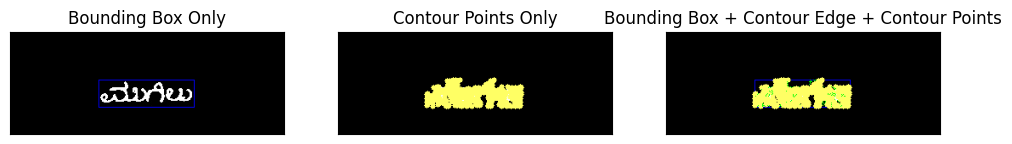

Feature Extraction Table:
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |    Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (104, 56, 112, 32) |  112  |   32   |     0      |      0      |     [0.]     |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_16/Segmentation_cell_16.jpg


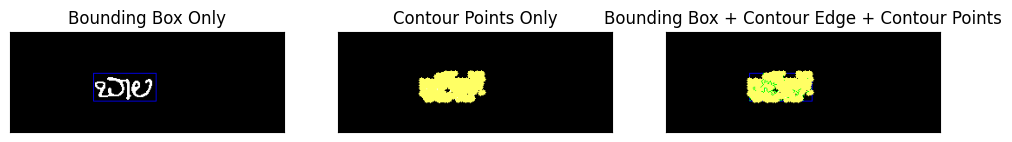

Feature Extraction Table:
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box   | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (96, 48, 72, 32) |  72   |   32   |     0      |      0      |     [0.]     |
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_7/Segmentation_cell_7.jpg


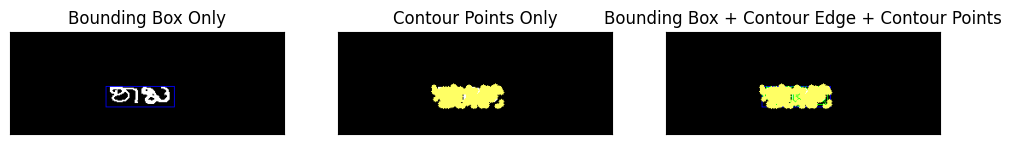

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (112, 64, 80, 24) |  80   |   24   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_11/Segmentation_cell_11.jpg


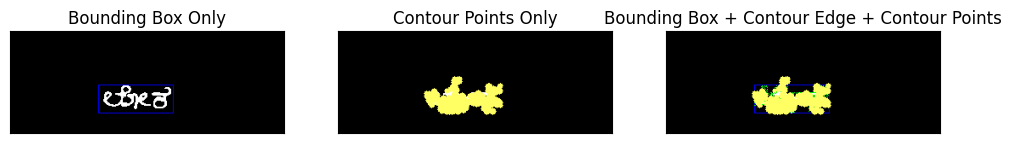

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (104, 63, 88, 33) |  88   |   33   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_5/Segmentation_cell_5.jpg


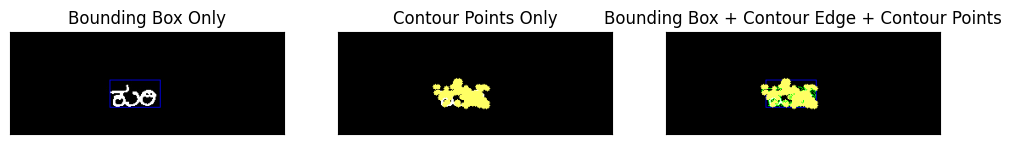

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (117, 56, 59, 32) |  59   |   32   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_1/Segmentation_cell_1.jpg


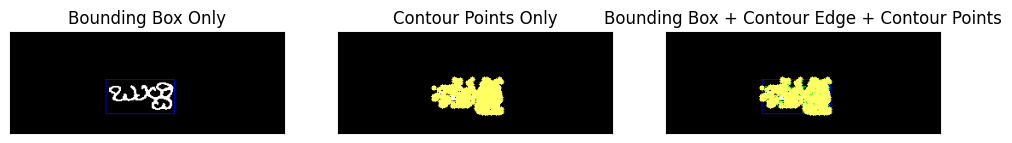

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (112, 56, 80, 40) |  80   |   40   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_12/Segmentation_cell_12.jpg


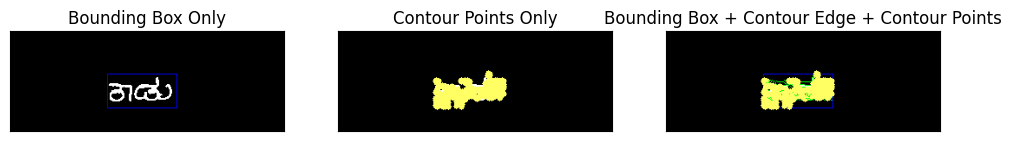

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (112, 49, 80, 39) |  80   |   39   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_13/Segmentation_cell_13.jpg


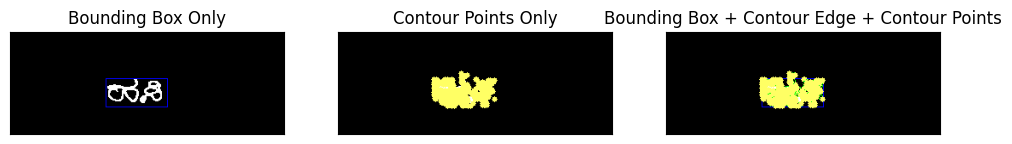

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (112, 55, 72, 33) |  72   |   33   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_6/Segmentation_cell_6.jpg


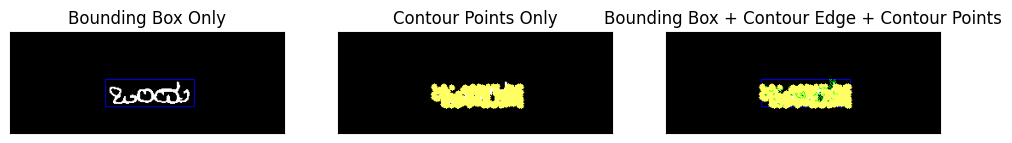

Feature Extraction Table:
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |    Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (112, 56, 104, 32) |  104  |   32   |     0      |      0      |     [0.]     |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_15/Segmentation_cell_15.jpg


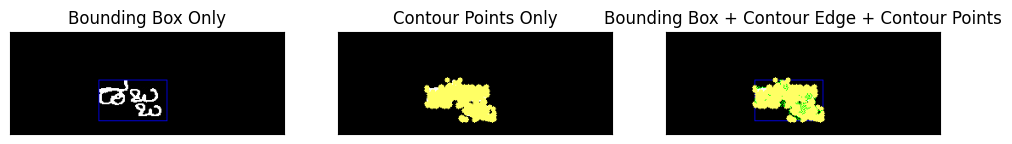

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (104, 56, 80, 48) |  80   |   48   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_18/Segmentation_cell_18.jpg


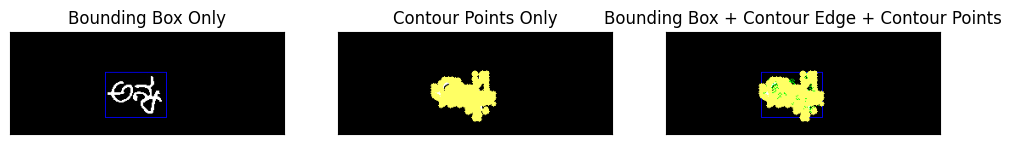

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (112, 48, 72, 53) |  72   |   53   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_4/Segmentation_cell_4.jpg


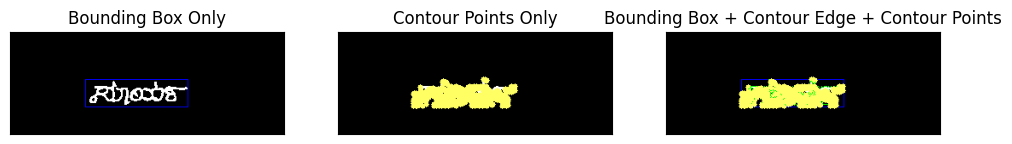

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (88, 56, 120, 32) |  120  |   32   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_3/Segmentation_cell_3.jpg


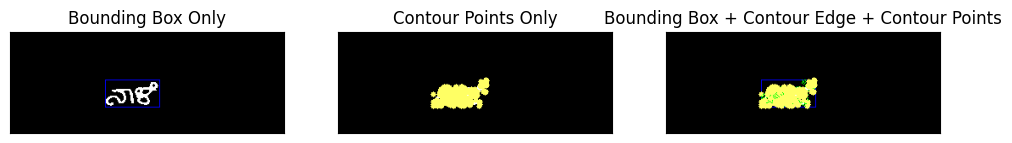

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (112, 56, 64, 32) |  64   |   32   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_2/Segmentation_cell_2.jpg


Exception ignored in: <function _xla_gc_callback at 0x7a6e081b51b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


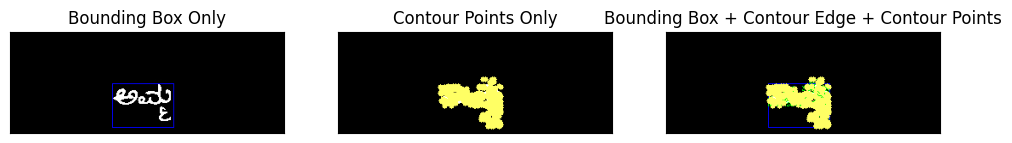

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (120, 61, 72, 51) |  72   |   51   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_9/Segmentation_cell_9.jpg


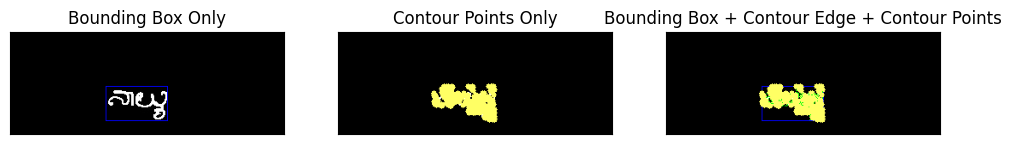

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (112, 64, 72, 40) |  72   |   40   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_17/Segmentation_cell_17.jpg


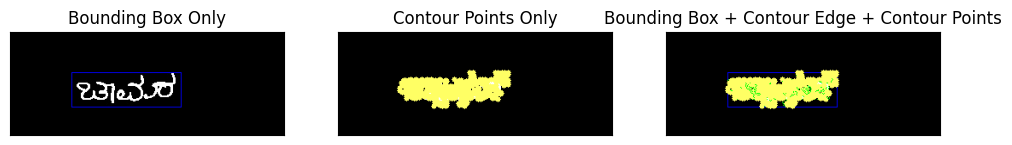

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (72, 48, 128, 40) |  128  |   40   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_14/Segmentation_cell_14.jpg


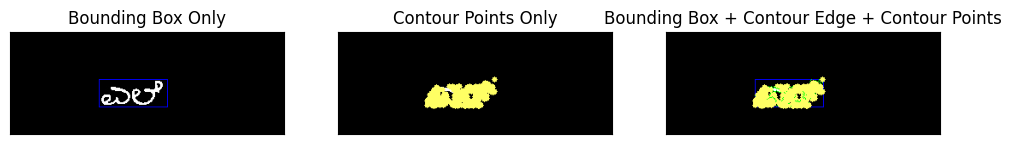

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (104, 56, 80, 32) |  80   |   32   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/arun_h/cell_8/Segmentation_cell_8.jpg


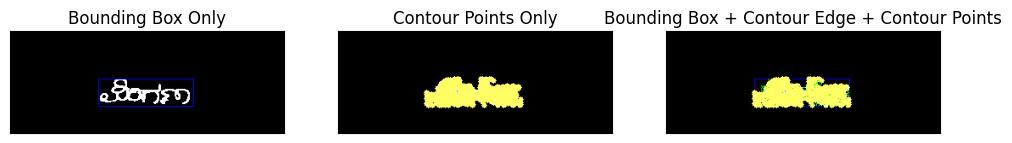

Feature Extraction Table:
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |    Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (104, 56, 112, 32) |  112  |   32   |     0      |      0      |     [0.]     |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_10/Segmentation_cell_10.jpg


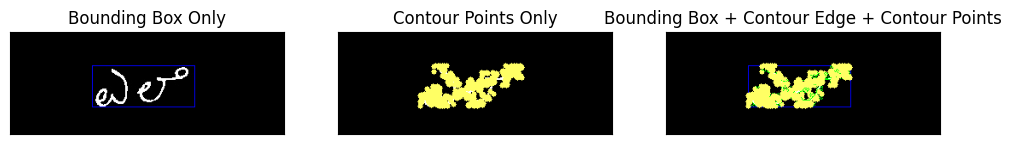

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (96, 40, 120, 48) |  120  |   48   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_7/Segmentation_cell_7.jpg


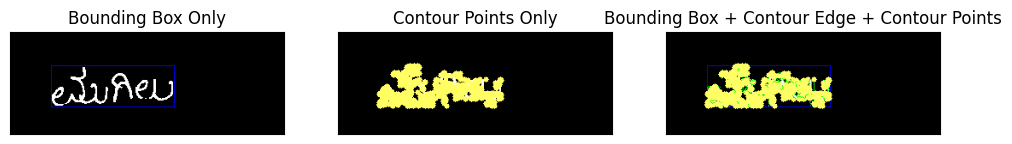

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (48, 40, 144, 48) |  144  |   48   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_11/Segmentation_cell_11.jpg


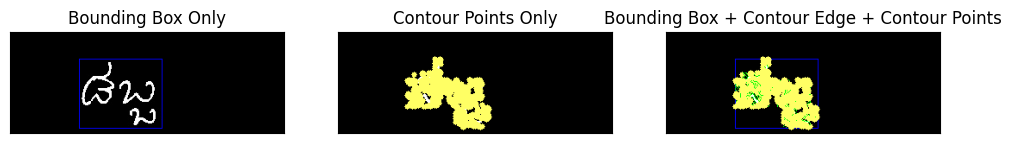

Feature Extraction Table:
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box   | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (80, 32, 96, 80) |  96   |   80   |     0      |      0      |     [0.]     |
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_5/Segmentation_cell_5.jpg


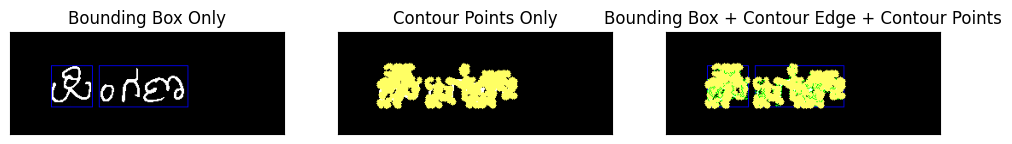

Feature Extraction Table:
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |    Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (104, 40, 104, 48) |  104  |   48   |    -56     |      0      |     [0.]     |
|   1   |  Char_2   |  (48, 40, 48, 48)  |  48   |   48   |    -56     |      0      |     [0.]     |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_1/Segmentation_cell_1.jpg


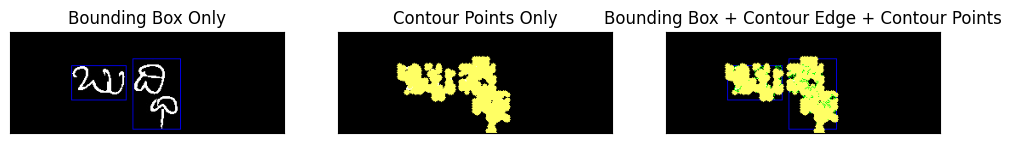

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (72, 40, 64, 40)  |  64   |   40   |     72     |     -8      | [-6.709837]  |
|   1   |  Char_2   | (144, 32, 56, 82) |  56   |   82   |     72     |     -8      | [-6.709837]  |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_12/Segmentation_cell_12.jpg


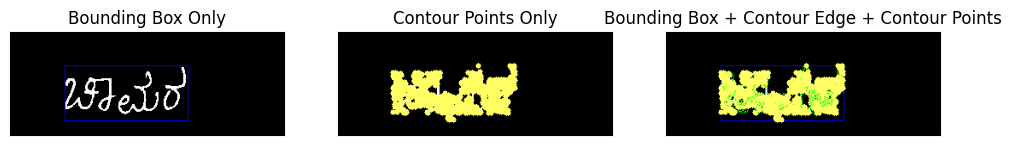

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (64, 40, 144, 64) |  144  |   64   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_13/Segmentation_cell_13.jpg


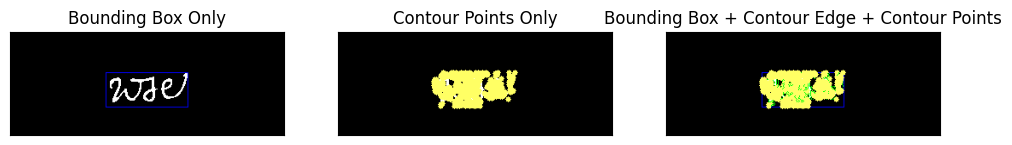

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (112, 48, 96, 40) |  96   |   40   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_6/Segmentation_cell_6.jpg


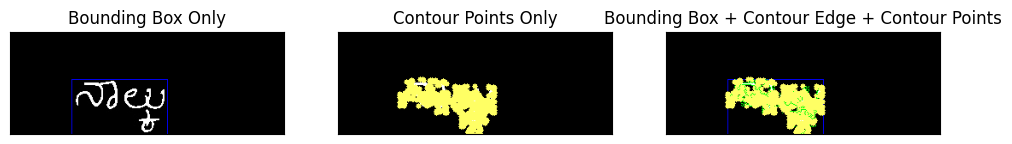

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (72, 56, 112, 64) |  112  |   64   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_4/Segmentation_cell_4.jpg


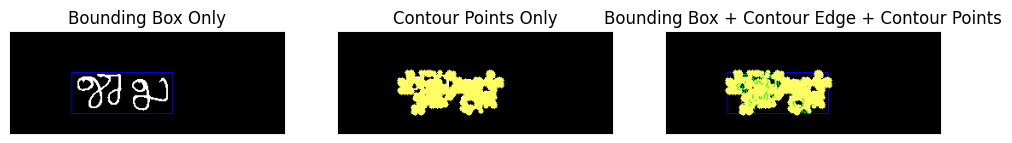

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (72, 48, 118, 48) |  118  |   48   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_3/Segmentation_cell_3.jpg


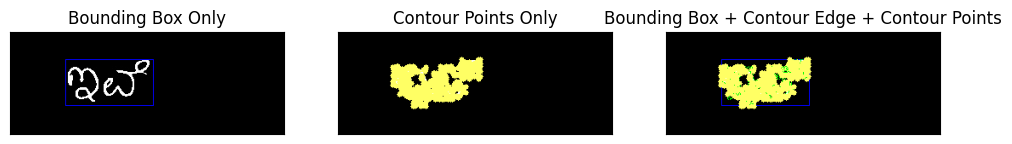

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (65, 32, 103, 54) |  103  |   54   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_2/Segmentation_cell_2.jpg


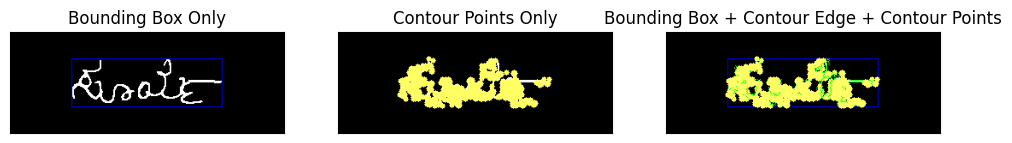

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (72, 32, 176, 56) |  176  |   56   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_9/Segmentation_cell_9.jpg


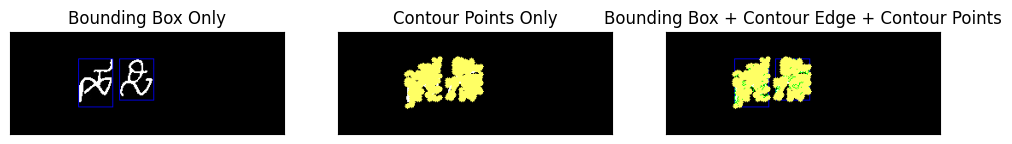

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (128, 32, 40, 48) |  40   |   48   |    -48     |      0      |     [0.]     |
|   1   |  Char_2   | (80, 32, 40, 56)  |  40   |   56   |    -48     |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_14/Segmentation_cell_14.jpg


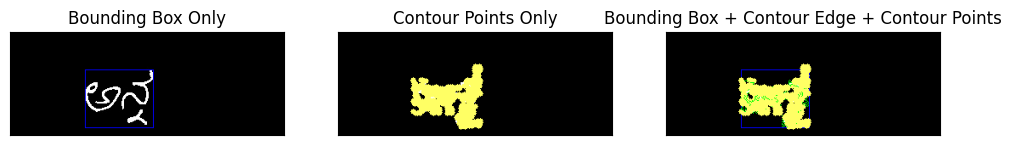

Feature Extraction Table:
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box   | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (88, 44, 80, 68) |  80   |   68   |     0      |      0      |     [0.]     |
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_8/Segmentation_cell_8.jpg


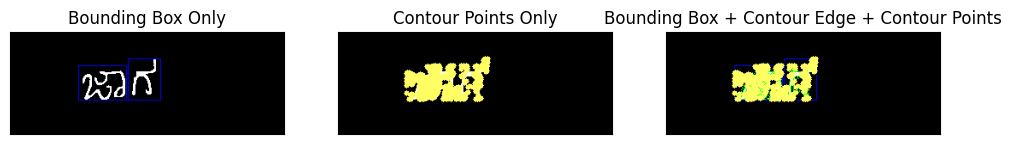

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (80, 40, 56, 40)  |  56   |   40   |     58     |     -8      | [-9.272602]  |
|   1   |  Char_2   | (138, 32, 38, 48) |  38   |   48   |     58     |     -8      | [-9.272602]  |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/nidhi_m/cell_20/Segmentation_cell_20.jpg


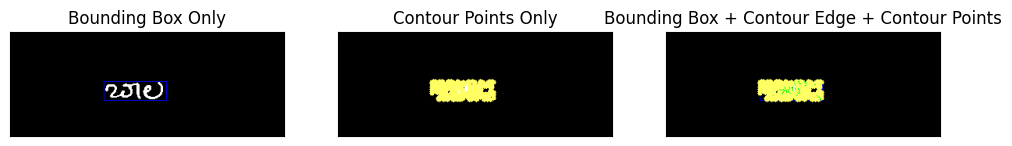

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (120, 64, 80, 24) |  80   |   24   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/nidhi_m/cell_10/Segmentation_cell_10.jpg


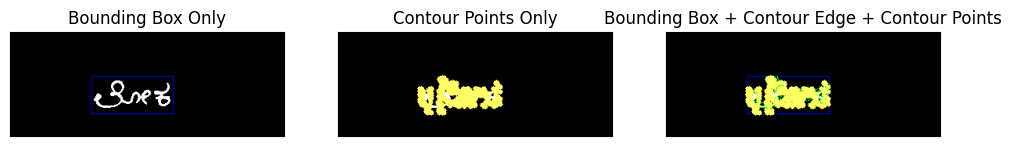

Feature Extraction Table:
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |    Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (104, 56, 104, 48) |  104  |   48   |     0      |      0      |     [0.]     |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/nidhi_m/cell_16/Segmentation_cell_16.jpg


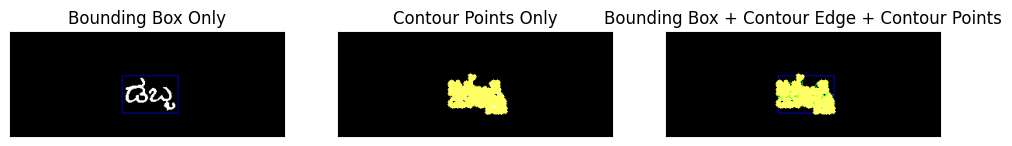

Feature Extraction Table:
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (144, 56, 72, 48) |  72   |   48   |     0      |      0      |     [0.]     |
+-------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/nidhi_m/cell_7/Segmentation_cell_7.jpg


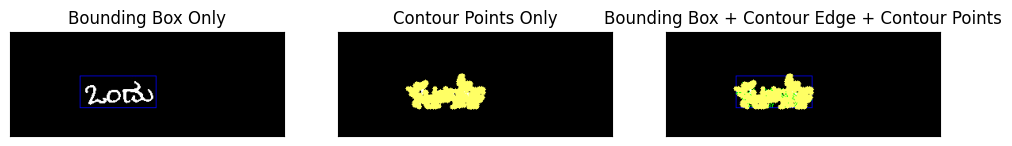

Feature Extraction Table:
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |   Bounding Box   | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (88, 56, 96, 40) |  96   |   40   |     0      |      0      |     [0.]     |
+-------+-----------+------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/nidhi_m/cell_11/Segmentation_cell_11.jpg


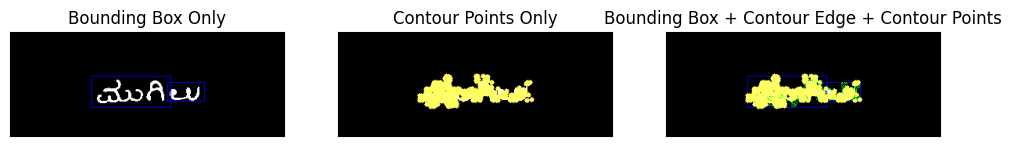

Feature Extraction Table:
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
| SI.No | Character |    Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
|   0   |  Char_1   | (201, 64, 47, 24)  |  47   |   24   |    -97     |     -8      |  [6.519802]  |
|   1   |  Char_2   | (104, 56, 101, 40) |  101  |   40   |    -97     |     -8      |  [6.519802]  |
+-------+-----------+--------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/nidhi_m/cell_5/Segmentation_cell_5.jpg


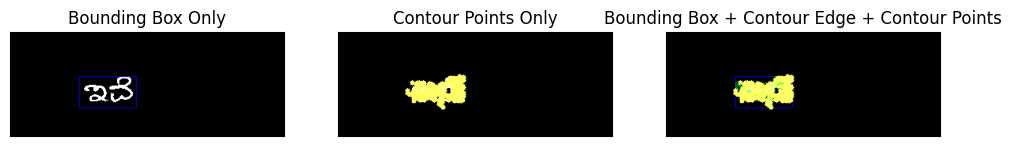

Feature Extraction Table:

KeyboardInterrupt: 

In [ ]:
import cv2
import pandas as pd
from tabulate import tabulate

def process_image(image_path):
    # Load the image
    inputCopy = cv2.imread(image_path)
    master_img_copy = inputCopy.copy()
    bb_only_img = inputCopy.copy()
    cc_only_img = inputCopy.copy()

    # Read the Segmentation image
    segmentation_normalised = cv2.imread(image_path.replace("Original_Image", "Segmentation"), cv2.IMREAD_GRAYSCALE)

    # Find contours
    contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    contours_poly = [None] * len(contours)
    boundRect = []
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

    # Filter bounding boxes based on width and height
    width_threshold = 10
    height_threshold = 10
    boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]

    # Draw rectangles and contours
    for box in boundRect:
        x, y, width, height = box
        cv2.rectangle(inputCopy, (x, y), (x + width, y + height), (255, 0, 0), 1)
        cv2.rectangle(bb_only_img, (x, y), (x + width, y + height), (255, 0, 0), 1)

    for c in contours:
        cv2.drawContours(inputCopy, [c], 0, (0, 255, 0), 1)
        epsilon = 0.1 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        for point in approx:
            cv2.circle(inputCopy, tuple(point[0]), 3, (100, 255, 255), -1)
            cv2.circle(cc_only_img, tuple(point[0]), 3, (100, 255, 255), -1)

    # Display images
    titles = ['Bounding Box Only', 'Contour Points Only', 'Bounding Box + Contour Edge + Contour Points']
    images = [bb_only_img, cc_only_img, inputCopy]

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)

    for i in np.arange(len(images)):
        plt.subplot(1, 3, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

    plt.show()

    # Extract features
    word_width = boundRect[-1][0] - boundRect[0][0]
    word_height = boundRect[-1][1] - boundRect[0][1]
    char_widths = [rect[2] for rect in boundRect]
    char_heights = [rect[3] for rect in boundRect]
    char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i + 1][0]) for i in range(len(boundRect) - 1)]
    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

    # Create DataFrame for feature extraction
    data = {'SI.No': list(range(len(boundRect))),
            'Character': [f'Char_{i+1}' for i in range(len(boundRect))],
            'Bounding Box': boundRect,
            'Width': char_widths,
            'Height': char_heights,
            'Word Width': [word_width] * len(boundRect),
            'Word Height': [word_height] * len(boundRect),
            'Skewed Angle': [skewed_angle] * len(boundRect)}

    df = pd.DataFrame(data)

    # Display the table
    print("Feature Extraction Table:")
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

    return inputCopy

# Process all images in the directory
directory = "/content/pp_images/"
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("Segmentation"):
            image_path = os.path.join(root, file)
            print("Processing image:", image_path)
            processed_image = process_image(image_path)


Processing image: /content/pp_images/arun_h/cell_10/Segmentation_cell_10.jpg


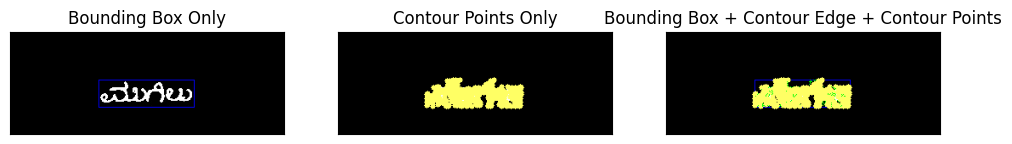

Processing image: /content/pp_images/arun_h/cell_16/Segmentation_cell_16.jpg


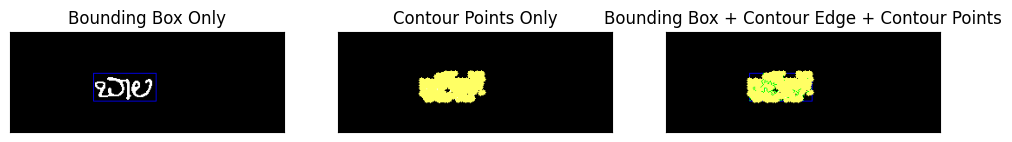

Processing image: /content/pp_images/arun_h/cell_7/Segmentation_cell_7.jpg


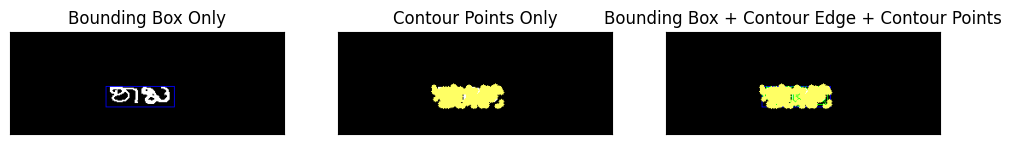

Processing image: /content/pp_images/arun_h/cell_11/Segmentation_cell_11.jpg


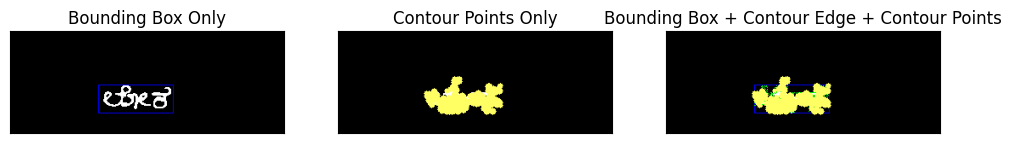

Processing image: /content/pp_images/arun_h/cell_5/Segmentation_cell_5.jpg


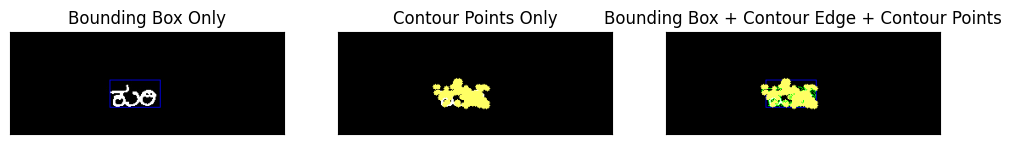

Processing image: /content/pp_images/arun_h/cell_1/Segmentation_cell_1.jpg


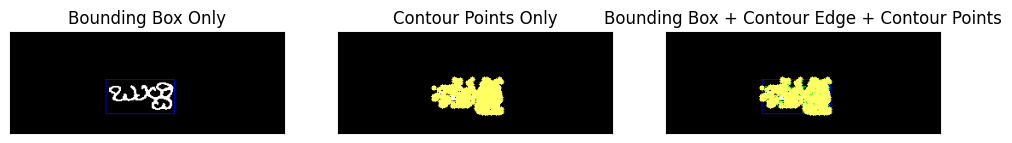

Processing image: /content/pp_images/arun_h/cell_12/Segmentation_cell_12.jpg


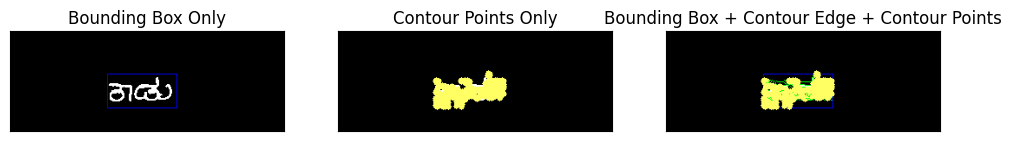

Processing image: /content/pp_images/arun_h/cell_13/Segmentation_cell_13.jpg


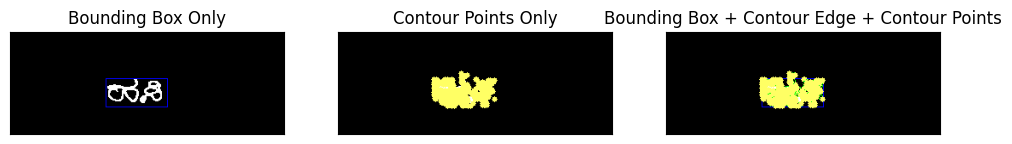

Processing image: /content/pp_images/arun_h/cell_6/Segmentation_cell_6.jpg


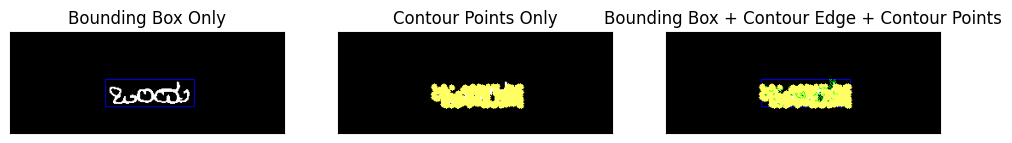

Processing image: /content/pp_images/arun_h/cell_15/Segmentation_cell_15.jpg


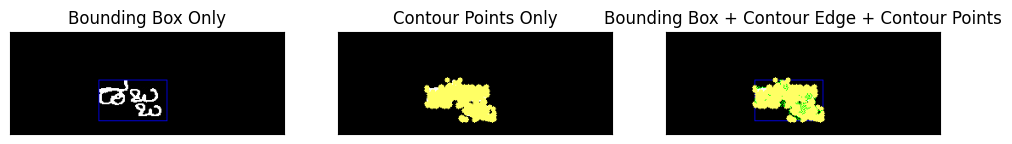

Processing image: /content/pp_images/arun_h/cell_18/Segmentation_cell_18.jpg


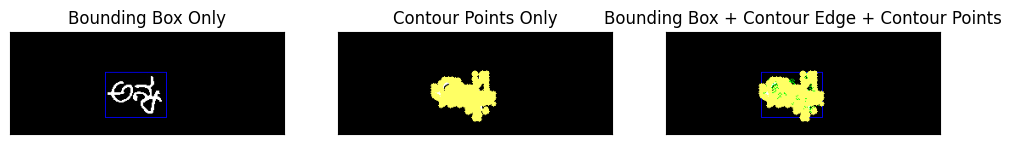

Processing image: /content/pp_images/arun_h/cell_4/Segmentation_cell_4.jpg


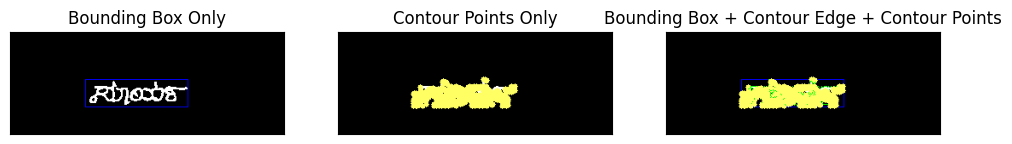

Processing image: /content/pp_images/arun_h/cell_3/Segmentation_cell_3.jpg


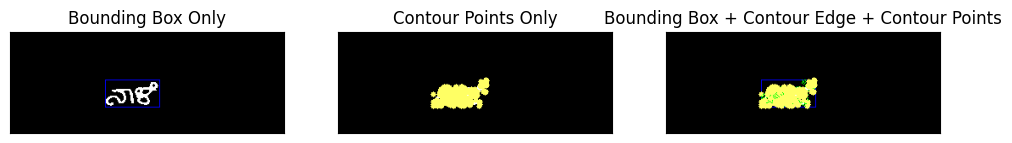

Processing image: /content/pp_images/arun_h/cell_2/Segmentation_cell_2.jpg


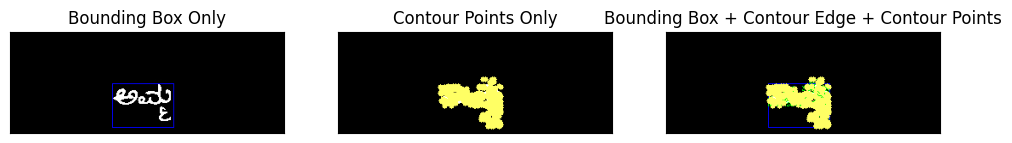

Processing image: /content/pp_images/arun_h/cell_9/Segmentation_cell_9.jpg


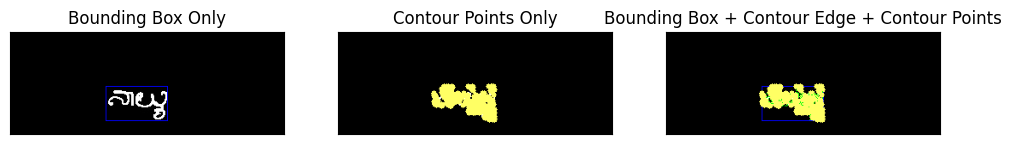

Processing image: /content/pp_images/arun_h/cell_17/Segmentation_cell_17.jpg


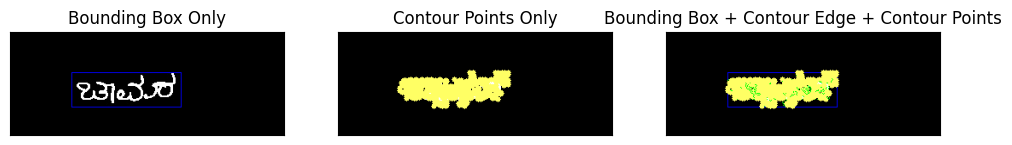

Processing image: /content/pp_images/arun_h/cell_14/Segmentation_cell_14.jpg


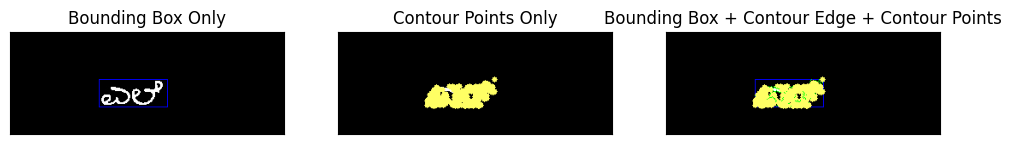

Processing image: /content/pp_images/arun_h/cell_8/Segmentation_cell_8.jpg


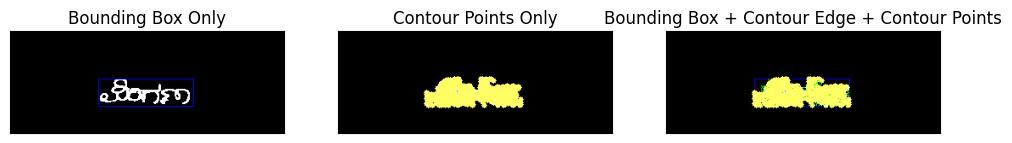

Processing image: /content/pp_images/sheetal_h/cell_10/Segmentation_cell_10.jpg


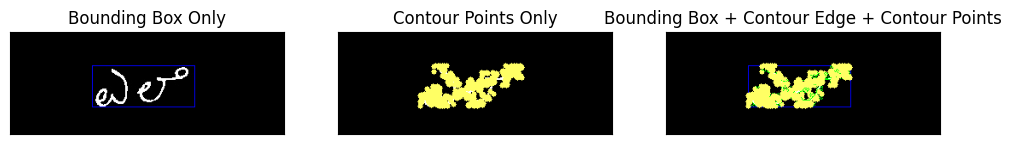

Processing image: /content/pp_images/sheetal_h/cell_7/Segmentation_cell_7.jpg


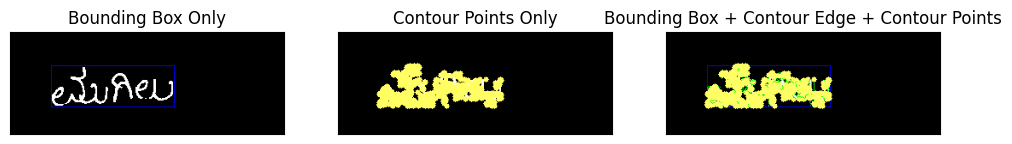

Processing image: /content/pp_images/sheetal_h/cell_11/Segmentation_cell_11.jpg


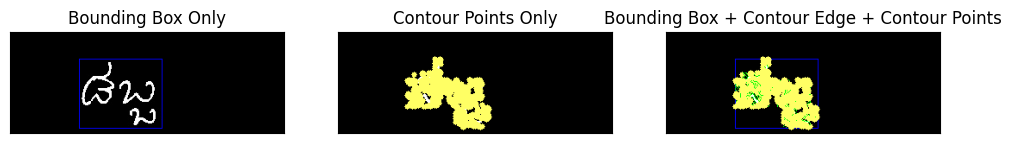

Processing image: /content/pp_images/sheetal_h/cell_5/Segmentation_cell_5.jpg


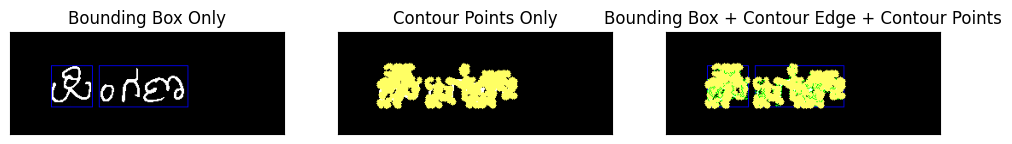

Processing image: /content/pp_images/sheetal_h/cell_1/Segmentation_cell_1.jpg


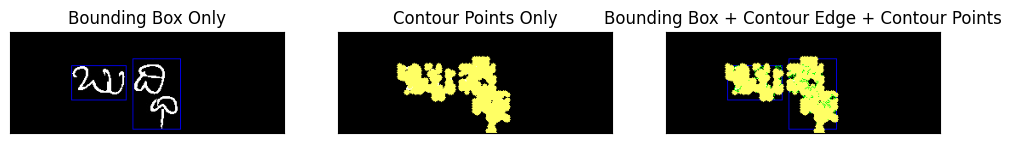

Processing image: /content/pp_images/sheetal_h/cell_12/Segmentation_cell_12.jpg


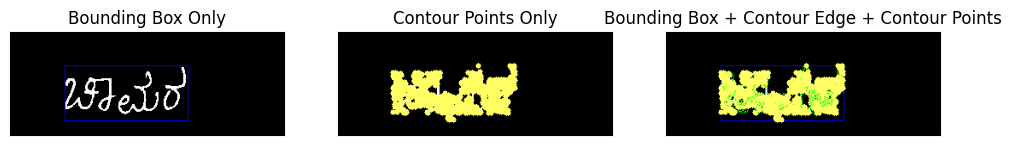

Processing image: /content/pp_images/sheetal_h/cell_13/Segmentation_cell_13.jpg


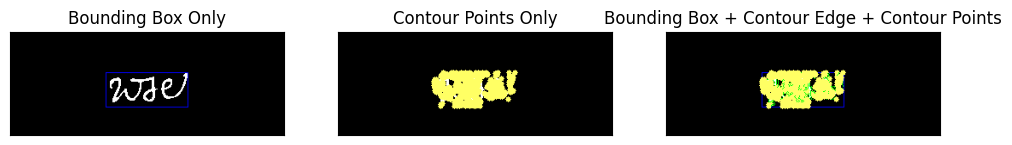

Processing image: /content/pp_images/sheetal_h/cell_6/Segmentation_cell_6.jpg


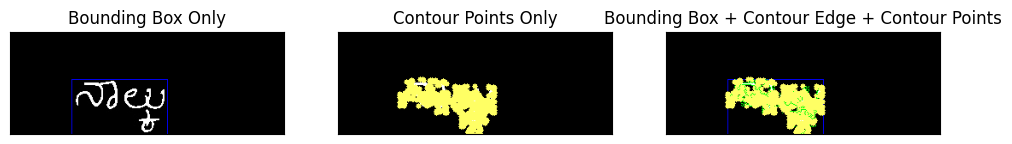

Processing image: /content/pp_images/sheetal_h/cell_4/Segmentation_cell_4.jpg


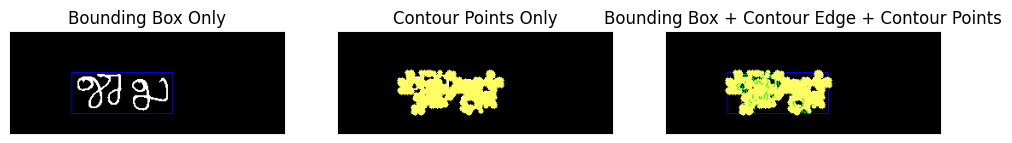

Processing image: /content/pp_images/sheetal_h/cell_3/Segmentation_cell_3.jpg


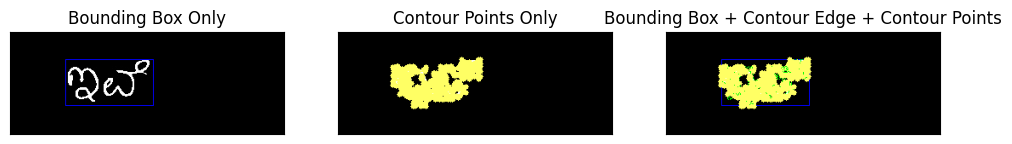

Processing image: /content/pp_images/sheetal_h/cell_2/Segmentation_cell_2.jpg


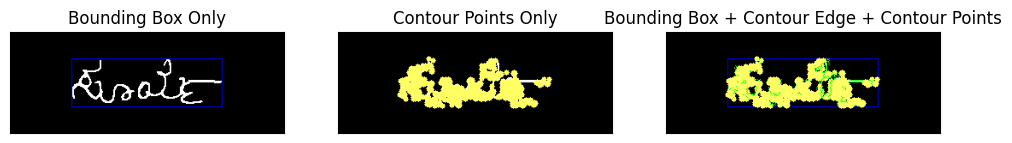

Processing image: /content/pp_images/sheetal_h/cell_9/Segmentation_cell_9.jpg


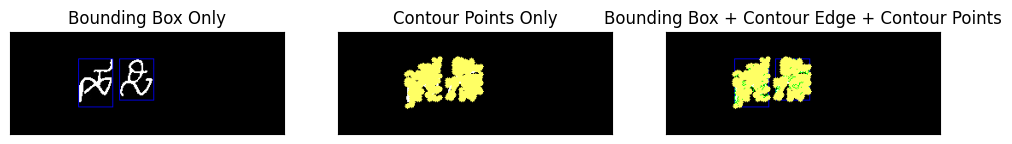

Processing image: /content/pp_images/sheetal_h/cell_14/Segmentation_cell_14.jpg


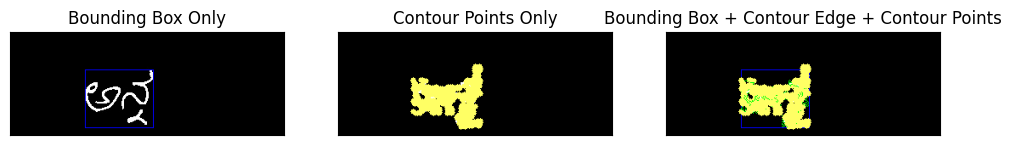

Processing image: /content/pp_images/sheetal_h/cell_8/Segmentation_cell_8.jpg


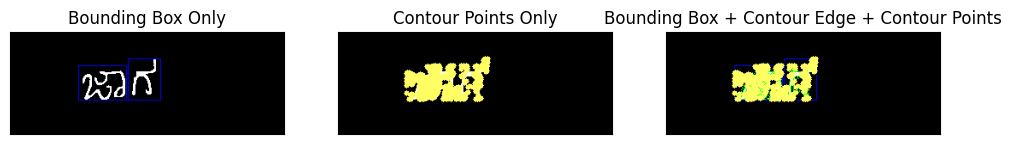

Processing image: /content/pp_images/nidhi_m/cell_20/Segmentation_cell_20.jpg


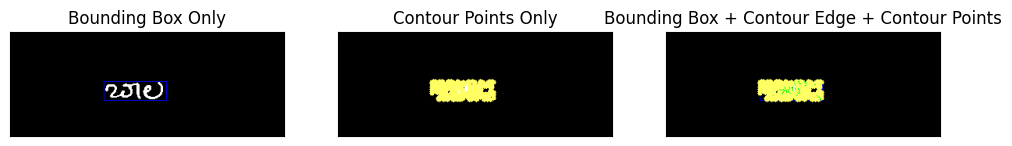

Processing image: /content/pp_images/nidhi_m/cell_10/Segmentation_cell_10.jpg


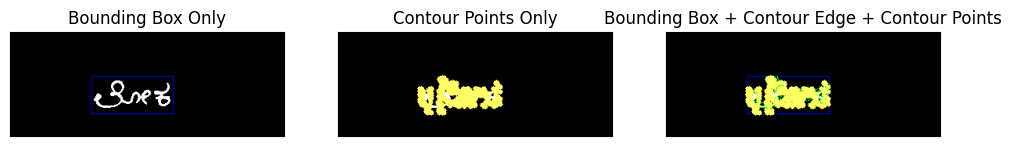

Processing image: /content/pp_images/nidhi_m/cell_16/Segmentation_cell_16.jpg


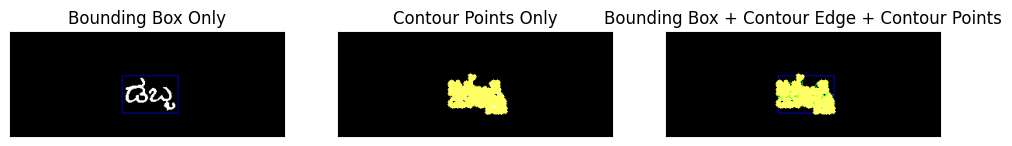

Processing image: /content/pp_images/nidhi_m/cell_7/Segmentation_cell_7.jpg


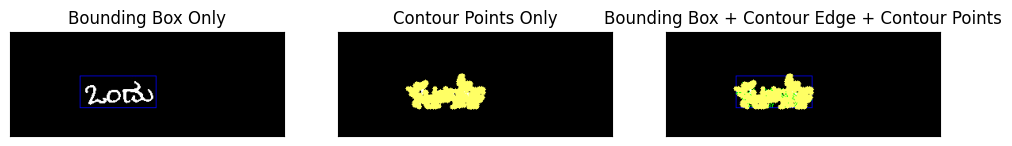

Processing image: /content/pp_images/nidhi_m/cell_11/Segmentation_cell_11.jpg


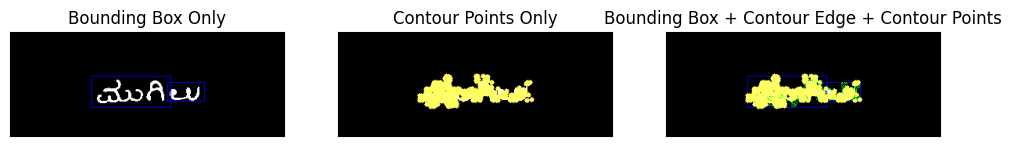

Processing image: /content/pp_images/nidhi_m/cell_5/Segmentation_cell_5.jpg


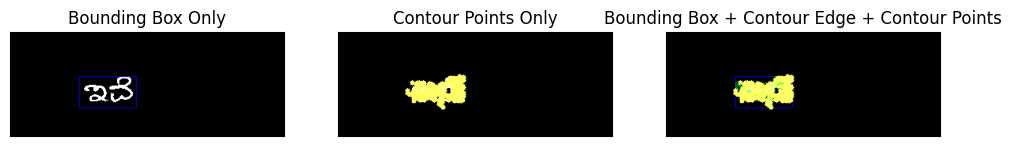

Processing image: /content/pp_images/nidhi_m/cell_1/Segmentation_cell_1.jpg


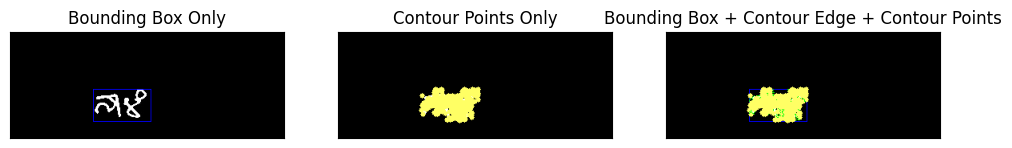

Processing image: /content/pp_images/nidhi_m/cell_12/Segmentation_cell_12.jpg


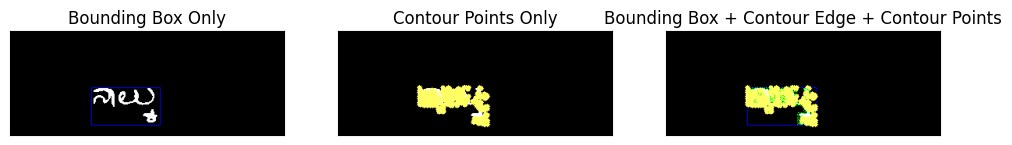

Processing image: /content/pp_images/nidhi_m/cell_13/Segmentation_cell_13.jpg


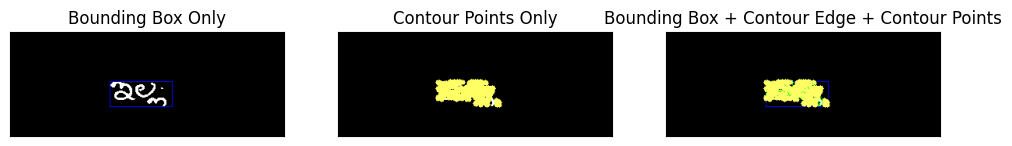

Processing image: /content/pp_images/nidhi_m/cell_19/Segmentation_cell_19.jpg


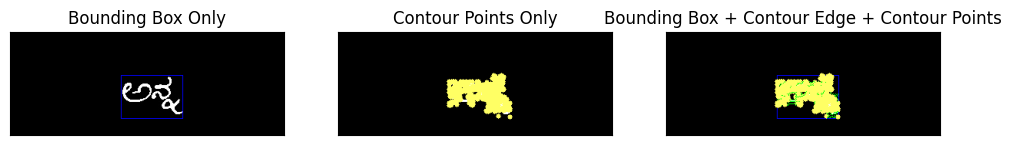

Processing image: /content/pp_images/nidhi_m/cell_6/Segmentation_cell_6.jpg


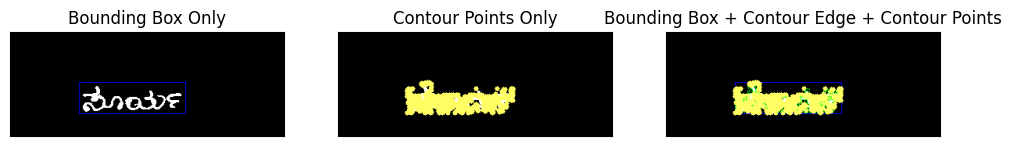

Processing image: /content/pp_images/nidhi_m/cell_15/Segmentation_cell_15.jpg


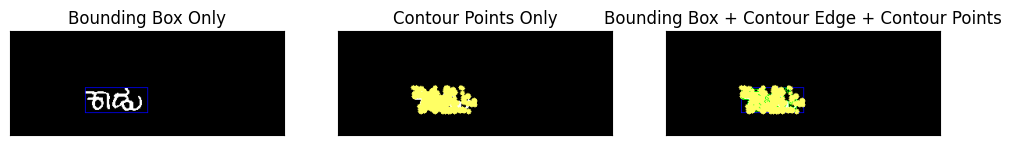

Processing image: /content/pp_images/nidhi_m/cell_18/Segmentation_cell_18.jpg


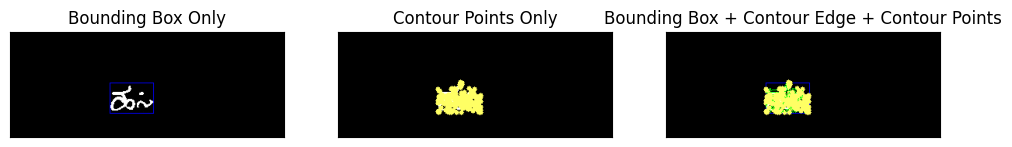

Processing image: /content/pp_images/nidhi_m/cell_4/Segmentation_cell_4.jpg


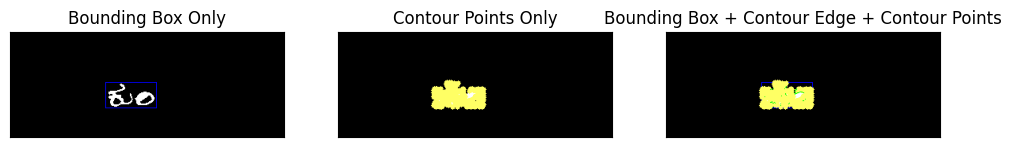

Processing image: /content/pp_images/nidhi_m/cell_3/Segmentation_cell_3.jpg


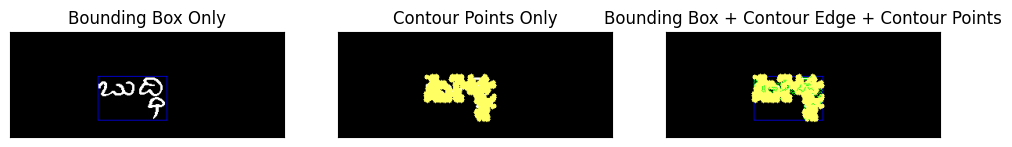

Processing image: /content/pp_images/nidhi_m/cell_2/Segmentation_cell_2.jpg


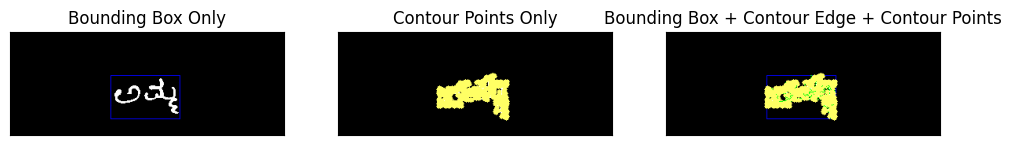

Processing image: /content/pp_images/nidhi_m/cell_9/Segmentation_cell_9.jpg


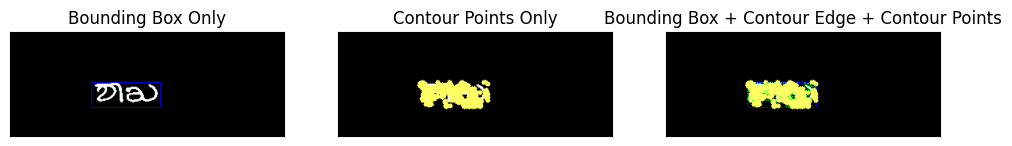

Processing image: /content/pp_images/nidhi_m/cell_17/Segmentation_cell_17.jpg


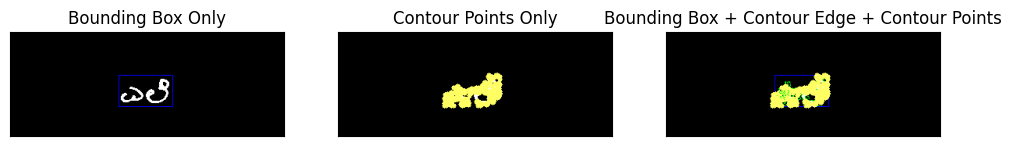

Processing image: /content/pp_images/nidhi_m/cell_21/Segmentation_cell_21.jpg


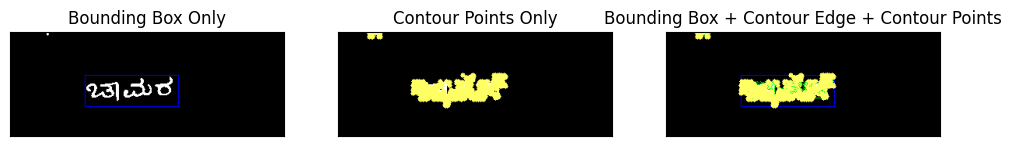

Processing image: /content/pp_images/nidhi_m/cell_14/Segmentation_cell_14.jpg


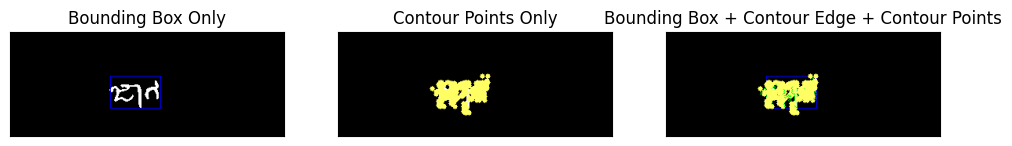

Processing image: /content/pp_images/nidhi_m/cell_8/Segmentation_cell_8.jpg


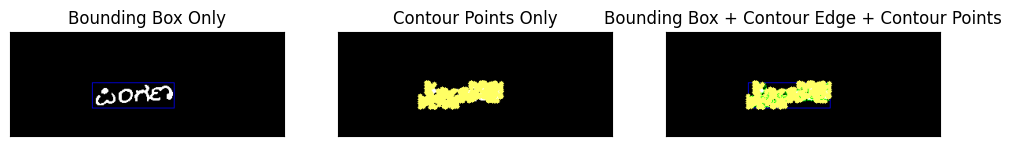

Processing image: /content/pp_images/umang_h/cell_20/Segmentation_cell_20.jpg


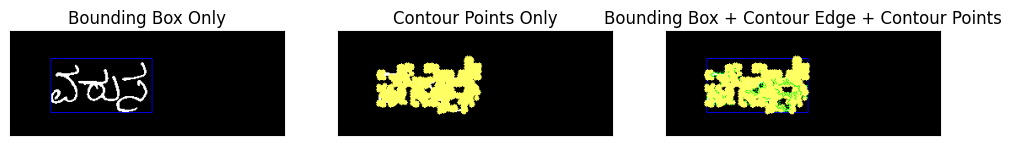

Processing image: /content/pp_images/umang_h/cell_10/Segmentation_cell_10.jpg


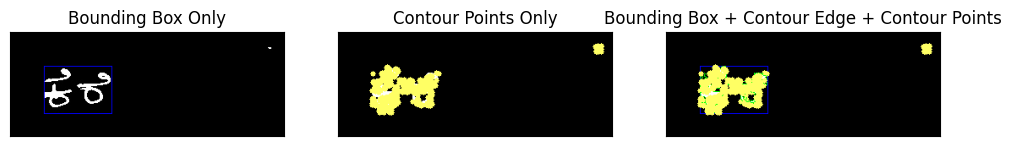

Processing image: /content/pp_images/umang_h/cell_16/Segmentation_cell_16.jpg


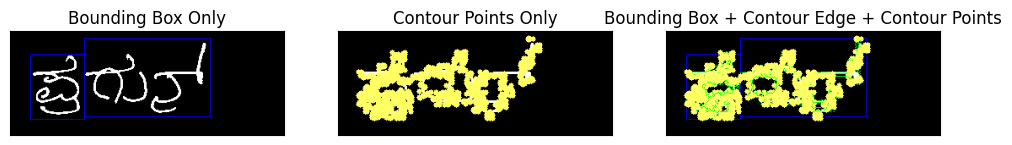

Processing image: /content/pp_images/umang_h/cell_7/Segmentation_cell_7.jpg


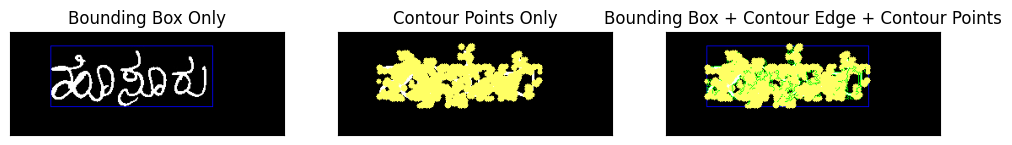

Processing image: /content/pp_images/umang_h/cell_11/Segmentation_cell_11.jpg


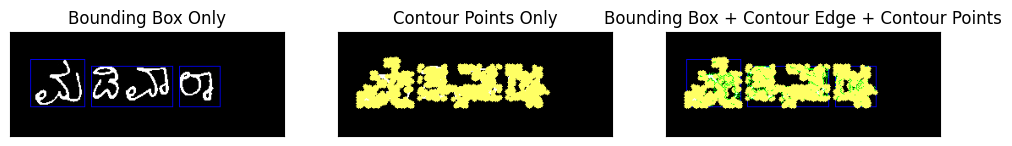

Processing image: /content/pp_images/umang_h/cell_5/Segmentation_cell_5.jpg


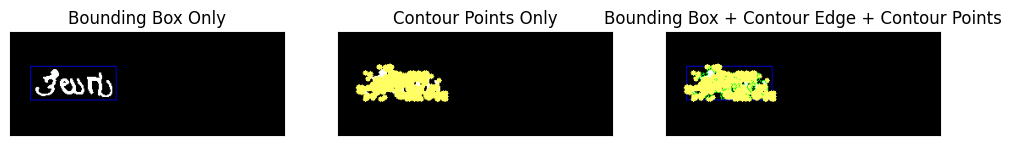

Processing image: /content/pp_images/umang_h/cell_1/Segmentation_cell_1.jpg


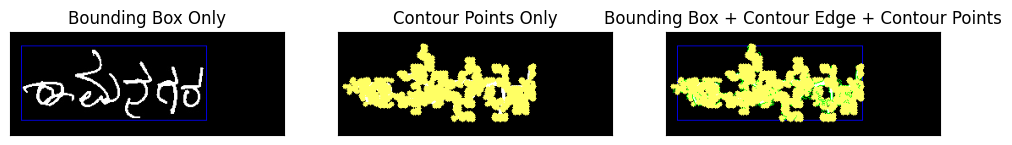

Processing image: /content/pp_images/umang_h/cell_12/Segmentation_cell_12.jpg


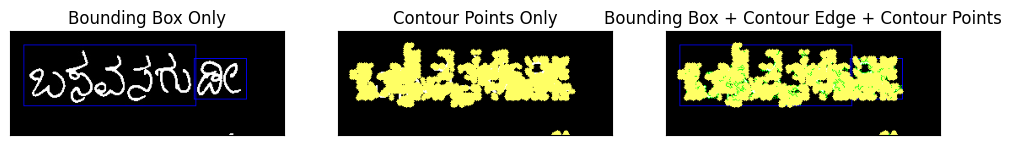

Processing image: /content/pp_images/umang_h/cell_13/Segmentation_cell_13.jpg


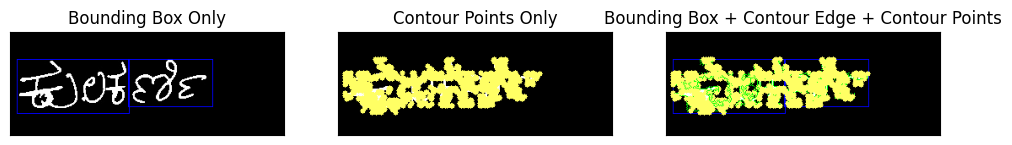

Processing image: /content/pp_images/umang_h/cell_19/Segmentation_cell_19.jpg


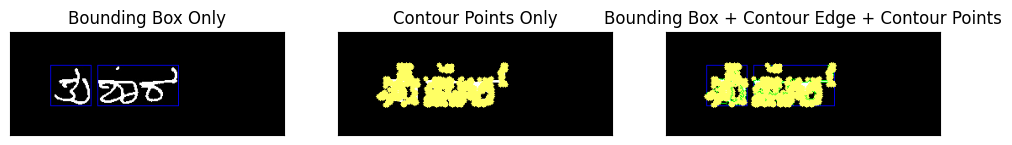

Processing image: /content/pp_images/umang_h/cell_6/Segmentation_cell_6.jpg


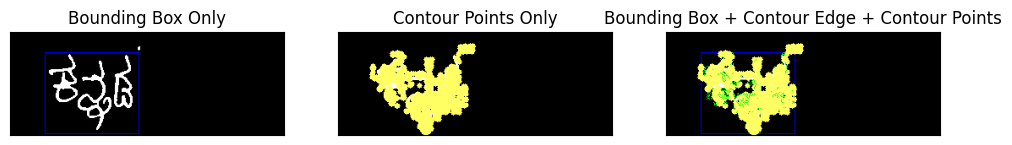

Processing image: /content/pp_images/umang_h/cell_15/Segmentation_cell_15.jpg


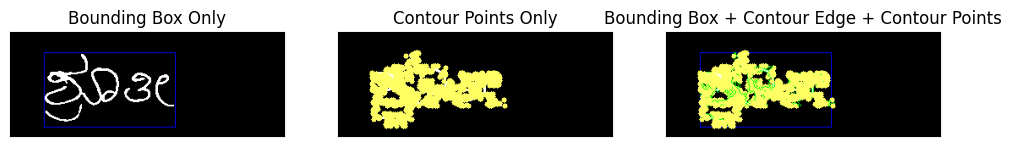

Processing image: /content/pp_images/umang_h/cell_18/Segmentation_cell_18.jpg


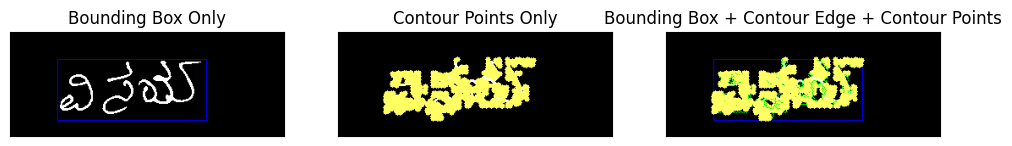

Processing image: /content/pp_images/umang_h/cell_4/Segmentation_cell_4.jpg


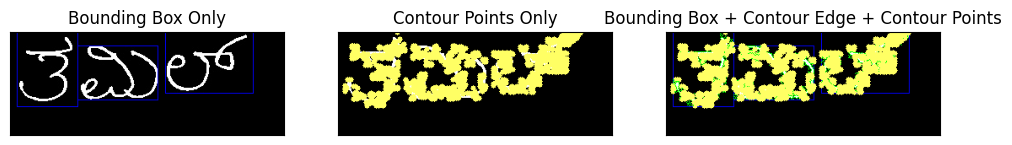

Processing image: /content/pp_images/umang_h/cell_3/Segmentation_cell_3.jpg


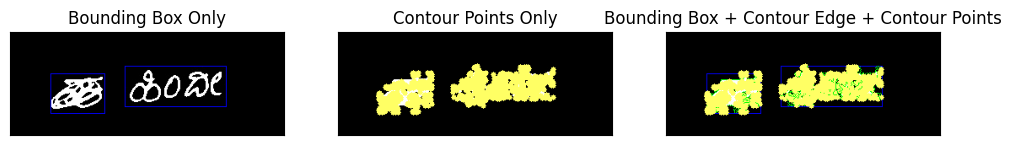

Processing image: /content/pp_images/umang_h/cell_2/Segmentation_cell_2.jpg


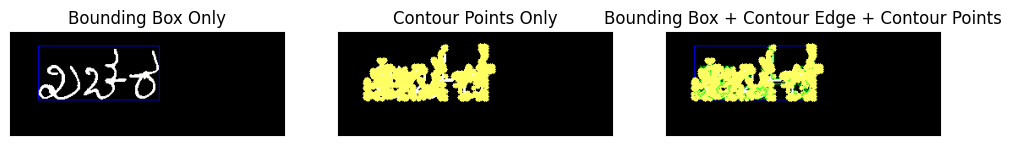

Processing image: /content/pp_images/umang_h/cell_9/Segmentation_cell_9.jpg


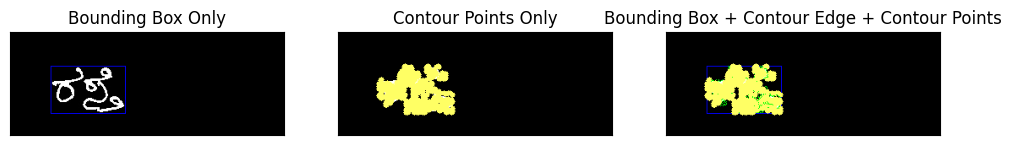

Processing image: /content/pp_images/umang_h/cell_17/Segmentation_cell_17.jpg


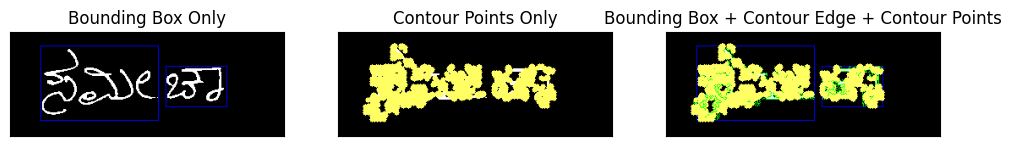

Processing image: /content/pp_images/umang_h/cell_21/Segmentation_cell_21.jpg


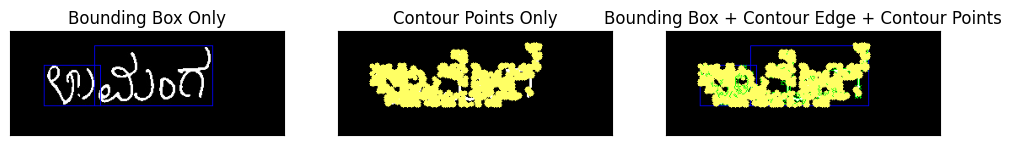

Processing image: /content/pp_images/umang_h/cell_14/Segmentation_cell_14.jpg


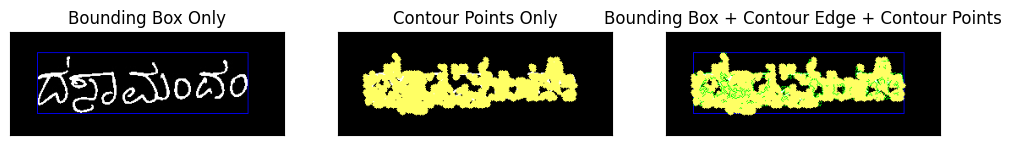

Processing image: /content/pp_images/umang_h/cell_8/Segmentation_cell_8.jpg


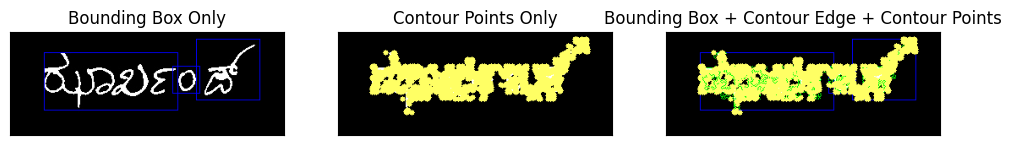

Processing image: /content/pp_images/suresh_l/cell_20/Segmentation_cell_20.jpg


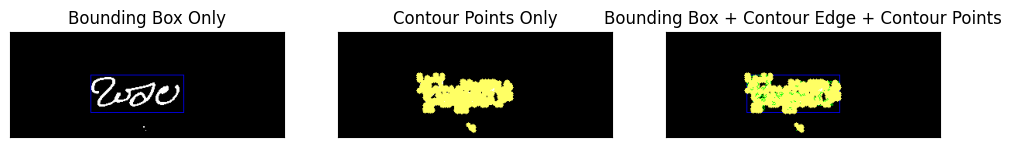

Processing image: /content/pp_images/suresh_l/cell_10/Segmentation_cell_10.jpg


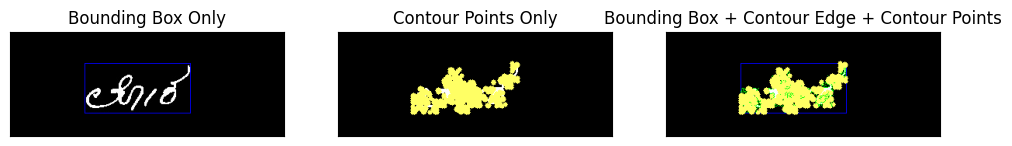

Processing image: /content/pp_images/suresh_l/cell_16/Segmentation_cell_16.jpg


KeyboardInterrupt: 

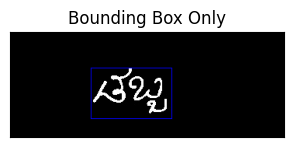

In [ ]:
import cv2
import pandas as pd
from tabulate import tabulate
import os

def process_image(image_path):
    # Extract datasheet name and cell/word from image path
    datasheet_name = os.path.basename(os.path.dirname(image_path))
    cell_word = os.path.basename(os.path.dirname(image_path))

    # Load the image
    inputCopy = cv2.imread(image_path)
    master_img_copy = inputCopy.copy()
    bb_only_img = inputCopy.copy()
    cc_only_img = inputCopy.copy()

    # Read the Segmentation image
    segmentation_normalised = cv2.imread(image_path.replace("Original_Image", "Segmentation"), cv2.IMREAD_GRAYSCALE)

    # Find contours
    contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    contours_poly = [None] * len(contours)
    boundRect = []
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

    # Filter bounding boxes based on width and height
    width_threshold = 10
    height_threshold = 10
    boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]

    # Draw rectangles and contours
    for box in boundRect:
        x, y, width, height = box
        cv2.rectangle(inputCopy, (x, y), (x + width, y + height), (255, 0, 0), 1)
        cv2.rectangle(bb_only_img, (x, y), (x + width, y + height), (255, 0, 0), 1)

    for c in contours:
        cv2.drawContours(inputCopy, [c], 0, (0, 255, 0), 1)
        epsilon = 0.1 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        for point in approx:
            cv2.circle(inputCopy, tuple(point[0]), 3, (100, 255, 255), -1)
            cv2.circle(cc_only_img, tuple(point[0]), 3, (100, 255, 255), -1)

    # Display images
    titles = ['Bounding Box Only', 'Contour Points Only', 'Bounding Box + Contour Edge + Contour Points']
    images = [bb_only_img, cc_only_img, inputCopy]

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)

    for i in np.arange(len(images)):
        plt.subplot(1, 3, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])

    plt.show()

    # Extract features
    word_width = boundRect[-1][0] - boundRect[0][0]
    word_height = boundRect[-1][1] - boundRect[0][1]
    char_widths = [rect[2] for rect in boundRect]
    char_heights = [rect[3] for rect in boundRect]
    char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i + 1][0]) for i in range(len(boundRect) - 1)]
    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

    # Create DataFrame for feature extraction
    data = {'SI.No': list(range(len(boundRect))),
            'Datasheet': [datasheet_name] * len(boundRect),
            'Cell/ Word': [cell_word] * len(boundRect),
            'Character': [f'Char_{i+1}' for i in range(len(boundRect))],
            'Bounding Box': boundRect,
            'Width': char_widths,
            'Height': char_heights,
            'Word Width': [word_width] * len(boundRect),
            'Word Height': [word_height] * len(boundRect),
            'Skewed Angle': [skewed_angle] * len(boundRect)}

    df = pd.DataFrame(data)

    return df

# Process all images in the directory
directory = "/content/pp_images"
dfs = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("Segmentation"):
            image_path = os.path.join(root, file)
            print("Processing image:", image_path)
            df = process_image(image_path)
            dfs.append(df)

# Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Display the combined table
print("Feature Extraction Table:")
print(tabulate(combined_df, headers='keys', tablefmt='pretty', showindex=False))


In [ ]:
import cv2
import pandas as pd
from tabulate import tabulate
import os

def process_image(image_path):
    # Extract datasheet name and cell/word from image path
    datasheet_name = os.path.basename(os.path.dirname(image_path))
    cell_word = os.path.basename(os.path.dirname(image_path))

    # Load the image
    inputCopy = cv2.imread(image_path)
    master_img_copy = inputCopy.copy()
    bb_only_img = inputCopy.copy()
    cc_only_img = inputCopy.copy()

    # Read the Segmentation image
    segmentation_normalised = cv2.imread(image_path.replace("Original_Image", "Segmentation"), cv2.IMREAD_GRAYSCALE)

    # Find contours
    contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    contours_poly = [None] * len(contours)
    boundRect = []
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

    # Filter bounding boxes based on width and height
    width_threshold = 10
    height_threshold = 10
    boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]

    # Draw rectangles and contours
    for box in boundRect:
        x, y, width, height = box
        cv2.rectangle(inputCopy, (x, y), (x + width, y + height), (255, 0, 0), 1)
        cv2.rectangle(bb_only_img, (x, y), (x + width, y + height), (255, 0, 0), 1)

    for c in contours:
        cv2.drawContours(inputCopy, [c], 0, (0, 255, 0), 1)
        epsilon = 0.1 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        for point in approx:
            cv2.circle(inputCopy, tuple(point[0]), 3, (100, 255, 255), -1)
            cv2.circle(cc_only_img, tuple(point[0]), 3, (100, 255, 255), -1)

    # Display images
    titles = ['Bounding Box Only', 'Contour Points Only', 'Bounding Box + Contour Edge + Contour Points']
    images = [bb_only_img, cc_only_img, inputCopy]

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)

    # for i in np.arange(len(images)):
    #     plt.subplot(1, 3, i + 1)
    #     plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    #     plt.title(titles[i])
    #     plt.xticks([]), plt.yticks([])

    # plt.show()

    # Extract features
    word_width = boundRect[-1][0] - boundRect[0][0]
    word_height = boundRect[-1][1] - boundRect[0][1]
    char_widths = [rect[2] for rect in boundRect]
    char_heights = [rect[3] for rect in boundRect]
    char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i + 1][0]) for i in range(len(boundRect) - 1)]
    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

    # Create DataFrame for feature extraction
    data = {'SI.No': list(range(len(boundRect))),
            'Datasheet': [datasheet_name] * len(boundRect),
            'Cell/ Word': [cell_word] * len(boundRect),
            'Character': [f'Char_{i+1}' for i in range(len(boundRect))],
            'Bounding Box': boundRect,
            'Width': char_widths,
            'Height': char_heights,
            'Word Width': [word_width] * len(boundRect),
            'Word Height': [word_height] * len(boundRect),
            'Skewed Angle': [skewed_angle] * len(boundRect)}

    df = pd.DataFrame(data)

    return df

# Process all images in the directory
directory = "/content/pp_images"
dfs = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("Segmentation"):
            image_path = os.path.join(root, file)
            print("Processing image:", image_path)
            df = process_image(image_path)
            dfs.append(df)

# Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Display the combined table
print("Feature Extraction Table:")
print(tabulate(combined_df, headers='keys', tablefmt='pretty', showindex=False))


Processing image: /content/pp_images/arun_h/cell_10/Segmentation_cell_10.jpg
Processing image: /content/pp_images/arun_h/cell_16/Segmentation_cell_16.jpg
Processing image: /content/pp_images/arun_h/cell_7/Segmentation_cell_7.jpg
Processing image: /content/pp_images/arun_h/cell_11/Segmentation_cell_11.jpg
Processing image: /content/pp_images/arun_h/cell_5/Segmentation_cell_5.jpg
Processing image: /content/pp_images/arun_h/cell_1/Segmentation_cell_1.jpg
Processing image: /content/pp_images/arun_h/cell_12/Segmentation_cell_12.jpg
Processing image: /content/pp_images/arun_h/cell_13/Segmentation_cell_13.jpg
Processing image: /content/pp_images/arun_h/cell_6/Segmentation_cell_6.jpg
Processing image: /content/pp_images/arun_h/cell_15/Segmentation_cell_15.jpg
Processing image: /content/pp_images/arun_h/cell_18/Segmentation_cell_18.jpg
Processing image: /content/pp_images/arun_h/cell_4/Segmentation_cell_4.jpg
Processing image: /content/pp_images/arun_h/cell_3/Segmentation_cell_3.jpg
Processing 

<ipython-input-46-12f174e67042>:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 5))


Processing image: /content/pp_images/sheetal_h/cell_13/Segmentation_cell_13.jpg
Processing image: /content/pp_images/sheetal_h/cell_6/Segmentation_cell_6.jpg
Processing image: /content/pp_images/sheetal_h/cell_4/Segmentation_cell_4.jpg
Processing image: /content/pp_images/sheetal_h/cell_3/Segmentation_cell_3.jpg
Processing image: /content/pp_images/sheetal_h/cell_2/Segmentation_cell_2.jpg
Processing image: /content/pp_images/sheetal_h/cell_9/Segmentation_cell_9.jpg
Processing image: /content/pp_images/sheetal_h/cell_14/Segmentation_cell_14.jpg
Processing image: /content/pp_images/sheetal_h/cell_8/Segmentation_cell_8.jpg
Processing image: /content/pp_images/nidhi_m/cell_20/Segmentation_cell_20.jpg
Processing image: /content/pp_images/nidhi_m/cell_10/Segmentation_cell_10.jpg
Processing image: /content/pp_images/nidhi_m/cell_16/Segmentation_cell_16.jpg
Processing image: /content/pp_images/nidhi_m/cell_7/Segmentation_cell_7.jpg
Processing image: /content/pp_images/nidhi_m/cell_11/Segmentat

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Processing image: /content/pp_images/sheetal_h/cell_10/Segmentation_cell_10.jpg


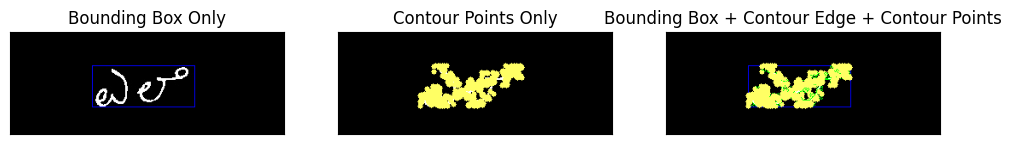

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_10  |  Char_1   | (96, 40, 120, 48) |  120  |   48   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_7/Segmentation_cell_7.jpg


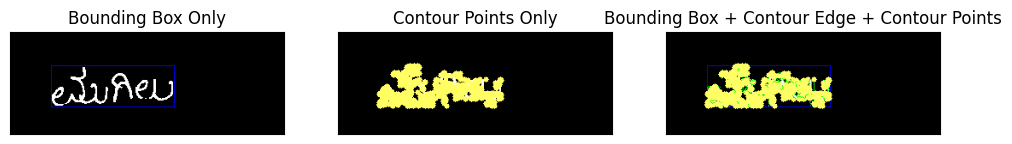

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_7   |  Char_1   | (48, 40, 144, 48) |  144  |   48   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_11/Segmentation_cell_11.jpg


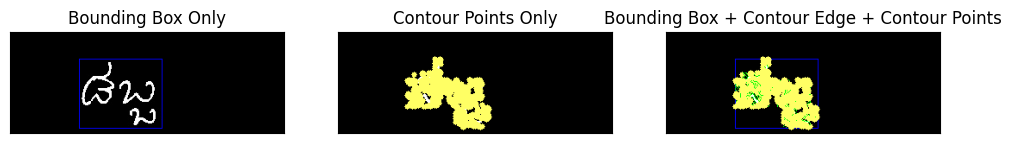

Feature Extraction Table:
+-------+-----------+-----------+-----------+------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box   | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_11  |  Char_1   | (80, 32, 96, 80) |  96   |   80   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_5/Segmentation_cell_5.jpg


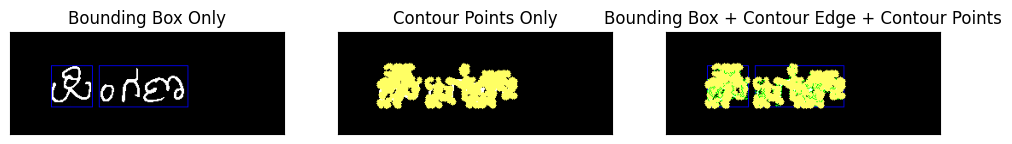

Feature Extraction Table:
+-------+-----------+-----------+-----------+--------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |    Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+--------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_5   |  Char_1   | (104, 40, 104, 48) |  104  |   48   |    -56     |      0      |     [0.]     |
|   1   | sheetal_h |  cell_5   |  Char_2   |  (48, 40, 48, 48)  |  48   |   48   |    -56     |      0      |     [0.]     |
+-------+-----------+-----------+-----------+--------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_1/Segmentation_cell_1.jpg


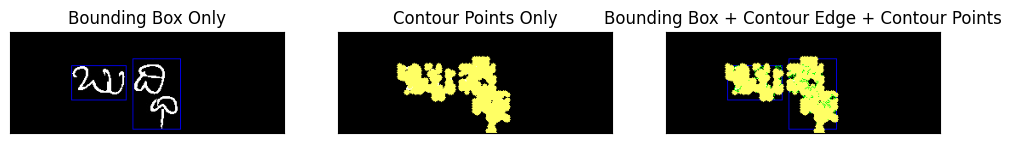

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_1   |  Char_1   | (72, 40, 64, 40)  |  64   |   40   |     72     |     -8      | [-6.709837]  |
|   1   | sheetal_h |  cell_1   |  Char_2   | (144, 32, 56, 82) |  56   |   82   |     72     |     -8      | [-6.709837]  |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_12/Segmentation_cell_12.jpg


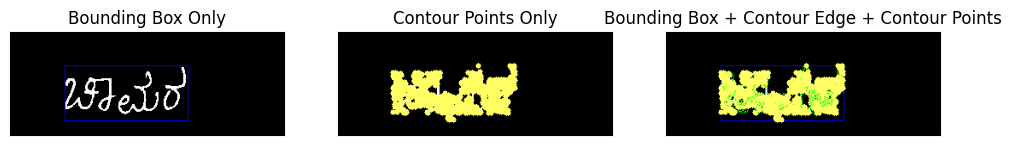

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_12  |  Char_1   | (64, 40, 144, 64) |  144  |   64   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_13/Segmentation_cell_13.jpg


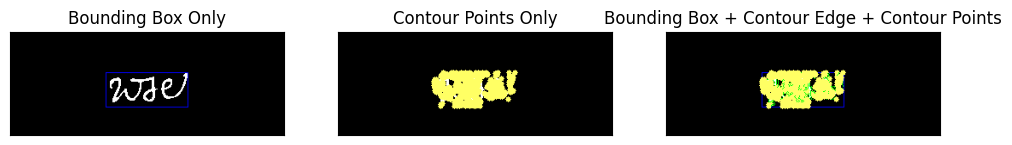

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_13  |  Char_1   | (112, 48, 96, 40) |  96   |   40   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_6/Segmentation_cell_6.jpg


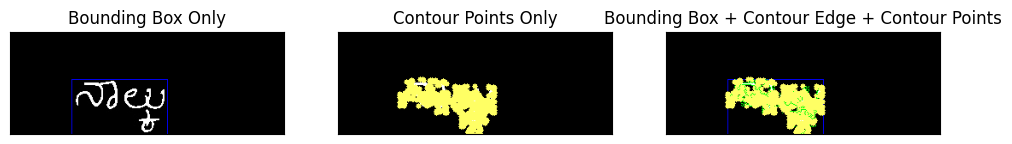

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_6   |  Char_1   | (72, 56, 112, 64) |  112  |   64   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_4/Segmentation_cell_4.jpg


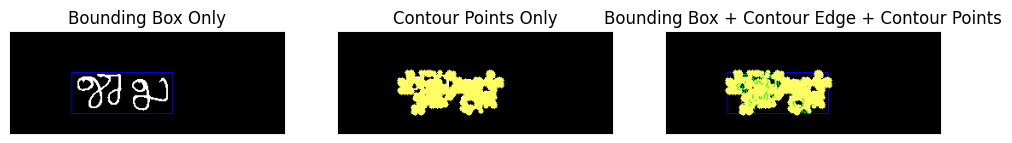

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_4   |  Char_1   | (72, 48, 118, 48) |  118  |   48   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_3/Segmentation_cell_3.jpg


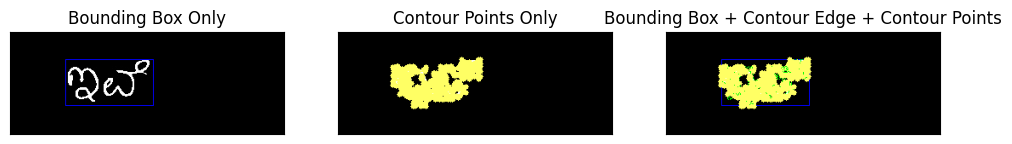

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_3   |  Char_1   | (65, 32, 103, 54) |  103  |   54   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_2/Segmentation_cell_2.jpg


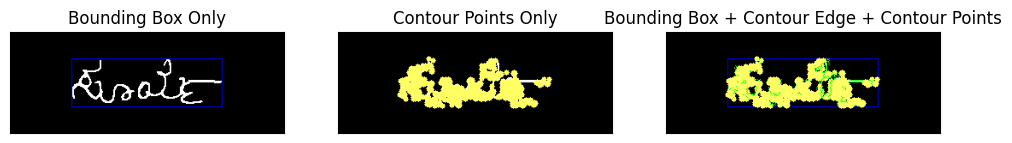

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_2   |  Char_1   | (72, 32, 176, 56) |  176  |   56   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_9/Segmentation_cell_9.jpg


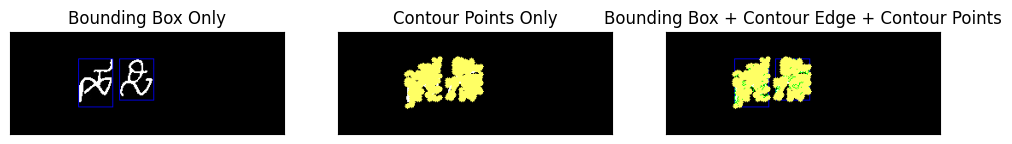

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_9   |  Char_1   | (128, 32, 40, 48) |  40   |   48   |    -48     |      0      |     [0.]     |
|   1   | sheetal_h |  cell_9   |  Char_2   | (80, 32, 40, 56)  |  40   |   56   |    -48     |      0      |     [0.]     |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_14/Segmentation_cell_14.jpg


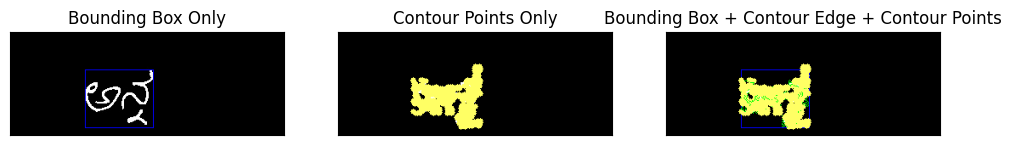

Feature Extraction Table:
+-------+-----------+-----------+-----------+------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box   | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_14  |  Char_1   | (88, 44, 80, 68) |  80   |   68   |     0      |      0      |     [0.]     |
+-------+-----------+-----------+-----------+------------------+-------+--------+------------+-------------+--------------+
Processing image: /content/pp_images/sheetal_h/cell_8/Segmentation_cell_8.jpg


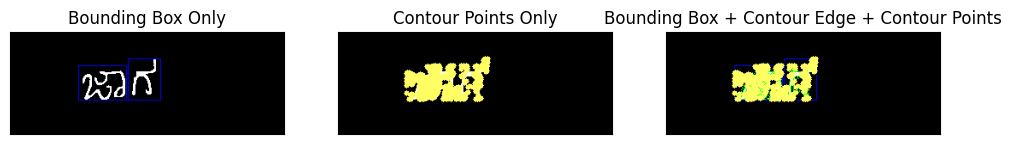

Feature Extraction Table:
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
| SI.No | Datasheet | Cell/Word | Character |   Bounding Box    | Width | Height | Word Width | Word Height | Skewed Angle |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+
|   0   | sheetal_h |  cell_8   |  Char_1   | (80, 40, 56, 40)  |  56   |   40   |     58     |     -8      | [-9.272602]  |
|   1   | sheetal_h |  cell_8   |  Char_2   | (138, 32, 38, 48) |  38   |   48   |     58     |     -8      | [-9.272602]  |
+-------+-----------+-----------+-----------+-------------------+-------+--------+------------+-------------+--------------+


In [ ]:
import cv2
import pandas as pd
from tabulate import tabulate
import os

def process_image(image_path):
    # Load the image
    inputCopy = cv2.imread(image_path)
    master_img_copy = inputCopy.copy()
    bb_only_img = inputCopy.copy()
    cc_only_img = inputCopy.copy()

    datasheet_name = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
    datasheet_pressure = datasheet_name.split('_')[-1]  # Extract pressure from datasheet name
    datasheet_name = datasheet_name[:-2]  # Remove pressure from datasheet name
    cell_word = os.path.basename(os.path.dirname(image_path))


    # Read the Segmentation image
    segmentation_normalised = cv2.imread(image_path.replace("Original_Image", "Segmentation"), cv2.IMREAD_GRAYSCALE)

    # Find contours
    contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    contours_poly = [None] * len(contours)
    boundRect = []
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

    # Filter bounding boxes based on width and height
    width_threshold = 10
    height_threshold = 10
    boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]

    # Draw rectangles and contours
    for box in boundRect:
        x, y, width, height = box
        cv2.rectangle(inputCopy, (x, y), (x + width, y + height), (255, 0, 0), 1)
        cv2.rectangle(bb_only_img, (x, y), (x + width, y + height), (255, 0, 0), 1)

    for c in contours:
        cv2.drawContours(inputCopy, [c], 0, (0, 255, 0), 1)
        epsilon = 0.1 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        for point in approx:
            cv2.circle(inputCopy, tuple(point[0]), 3, (100, 255, 255), -1)
            cv2.circle(cc_only_img, tuple(point[0]), 3, (100, 255, 255), -1)

    # Display images
    titles = ['Bounding Box Only', 'Contour Points Only', 'Bounding Box + Contour Edge + Contour Points']
    images = [bb_only_img, cc_only_img, inputCopy]

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)

    if datasheet_name == "sheetal":
      for i in np.arange(len(images)):
        plt.subplot(1, 3, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])
      plt.show()


    # for i in np.arange(len(images)):
    #     plt.subplot(1, 3, i + 1)
    #     plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    #     plt.title(titles[i])
    #     plt.xticks([]), plt.yticks([])

    # plt.show()

    # Extract features
    word_width = boundRect[-1][0] - boundRect[0][0]
    word_height = boundRect[-1][1] - boundRect[0][1]
    char_widths = [rect[2] for rect in boundRect]
    char_heights = [rect[3] for rect in boundRect]
    char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i + 1][0]) for i in range(len(boundRect) - 1)]
    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

    # Extract datasheet name and cell/word name from the image path
    image_parts = image_path.split("/")
    datasheet_name = image_parts[-3]
    cell_name = image_parts[-2]

    # Create DataFrame for feature extraction
    data = {'SI.No': list(range(len(boundRect))),
            'Datasheet': [datasheet_name] * len(boundRect),
            'Cell/Word': [cell_name] * len(boundRect),
            'Character': [f'Char_{i+1}' for i in range(len(boundRect))],
            'Bounding Box': boundRect,
            'Width': char_widths,
            'Height': char_heights,
            'Word Width': [word_width] * len(boundRect),
            'Word Height': [word_height] * len(boundRect),
            'Skewed Angle': [skewed_angle] * len(boundRect)}

    df = pd.DataFrame(data)

    # Display the table
    print("Feature Extraction Table:")
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))

    return inputCopy

# Process all images in the directory
directory = "/content/pp_images/sheetal_h"
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("Segmentation"):
            image_path = os.path.join(root, file)
            print("Processing image:", image_path)
            processed_image = process_image(image_path)


In [ ]:
import cv2
import pandas as pd
from tabulate import tabulate
import os

def process_image(image_path):
    # Extract datasheet name and cell/word from image path
    datasheet_name = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
    cell_word = os.path.basename(os.path.dirname(image_path))

    # Load the image
    inputCopy = cv2.imread(image_path)
    master_img_copy = inputCopy.copy()
    bb_only_img = inputCopy.copy()
    cc_only_img = inputCopy.copy()

    # Read the Segmentation image
    segmentation_normalised = cv2.imread(image_path.replace("Original_Image", "Segmentation"), cv2.IMREAD_GRAYSCALE)

    # Find contours
    contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    contours_poly = [None] * len(contours)
    boundRect = []
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

    # Filter bounding boxes based on width and height
    width_threshold = 10
    height_threshold = 10
    boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]

    # Extract features
    word_width = boundRect[-1][0] - boundRect[0][0]
    word_height = boundRect[-1][1] - boundRect[0][1]
    char_widths = [rect[2] for rect in boundRect]
    char_heights = [rect[3] for rect in boundRect]
    char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i + 1][0]) for i in range(len(boundRect) - 1)]
    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

    # Create DataFrame for feature extraction
    data = {
            'Datasheet': [datasheet_name] * len(boundRect),
            'Cell/ Word': [cell_word] * len(boundRect),
            'Character': [f'Char_{i+1}' for i in range(len(boundRect))],
            'Bounding Box': boundRect,
            'Width': char_widths,
            'Height': char_heights,
            'Word Width': [word_width] * len(boundRect),
            'Word Height': [word_height] * len(boundRect),
            'Skewed Angle': [skewed_angle] * len(boundRect)}

    df = pd.DataFrame(data)

    return df

# Process all images in the directory
directory = "/content/pp_images"
dfs = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("Segmentation"):
            image_path = os.path.join(root, file)
            print("Processing image:", image_path)
            df = process_image(image_path)
            dfs.append(df)

# Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Reset the index to start from 0 and increment
combined_df.insert(0, 'SI.No', combined_df.index + 1)

# Display the combined table
print("Feature Extraction Table:")
print(tabulate(combined_df, headers='keys', tablefmt='pretty', showindex=False))


CSV file saved successfully.


In [ ]:
def process_image(image_path):
    # Extract datasheet name and cell/word from image path
    datasheet_name = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
    datasheet_pressure = datasheet_name.split('_')[-1]  # Extract pressure from datasheet name
    datasheet_name = datasheet_name[:-2]  # Remove pressure from datasheet name
    cell_word = os.path.basename(os.path.dirname(image_path))

    # Load the image
    inputCopy = cv2.imread(image_path)
    master_img_copy = inputCopy.copy()
    bb_only_img = inputCopy.copy()
    cc_only_img = inputCopy.copy()

    # Read the Segmentation image
    segmentation_normalised = cv2.imread(image_path.replace("Original_Image", "Segmentation"), cv2.IMREAD_GRAYSCALE)

    # Find contours
    contours, hierarchy = cv2.findContours(segmentation_normalised, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    contours_poly = [None] * len(contours)
    boundRect = []
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

    # Filter bounding boxes based on width and height
    width_threshold = 10
    height_threshold = 10
    boundRect = [rect for rect in boundRect if rect[2] > width_threshold and rect[3] > height_threshold]
    boundRect = sorted(boundRect)

    # Display images
    titles = ['Bounding Box Only', 'Contour Points Only', 'Bounding Box + Contour Edge + Contour Points']
    images = [bb_only_img, cc_only_img, inputCopy]

    # plt.figure(figsize=(12, 5))
    # plt.subplots_adjust(hspace=0.5)

    # if datasheet_name == "sheetal":
    #   for i in np.arange(len(images)):
    #       plt.subplot(1, 3, i + 1)
    #       plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    #       plt.title(titles[i])
    #       plt.xticks([]), plt.yticks([])

    #   plt.show()

    print("boundRect :" , boundRect)
    # Extract features
    word_width = boundRect[-1][0] - boundRect[0][0]
    word_height = boundRect[-1][1] - boundRect[0][1]
    # Calculate word_width and word_height based on multiple bounding boxes
    if len(boundRect) > 1:
        word_width = sum([rect[2] for rect in boundRect])
        word_height = sum([rect[3] for rect in boundRect])
    else:
        word_width = boundRect[0][2] if word_width <= 0 else word_width
        word_height = boundRect[0][3] if word_height <= 0 else word_height
    char_widths = [rect[2] for rect in boundRect]
    char_heights = [rect[3] for rect in boundRect]

    # char_gaps = []
    # if len(boundRect) > 1:
    #     # Calculate character gaps for all characters by using difference between vertical last line of first character and first vertical bounding box line of second character
    #     char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i+1][0]) for i in range(len(boundRect)-1)]

    #     # Fill the first row of character gaps
    #     if len(char_gaps) > 0:
    #         char_gaps.append(char_gaps[-1])
    #     else:
    #         char_gaps.extend([0] * (len(boundRect)-1))
    # else:
    #     char_gaps = [0] * len(boundRect)


    char_gaps = [abs((boundRect[i][0] + boundRect[i][2]) - boundRect[i+1][0]) for i in range(len(boundRect)-1)]
    # Fill the first row of character gaps
    char_gaps = char_gaps + [char_gaps[-1]] if len(char_gaps) > 0 else [0] * len(boundRect)

    # Convert char_gaps to tuples
    char_gaps = [(gap) for gap in char_gaps]


    # Ensure char_gaps has the same length as boundRect
    # char_gaps.extend([0] * (len(boundRect) - len(char_gaps)))
    top_points = [(rect[0] + rect[2] // 2, rect[1]) for rect in boundRect]
    vx, vy, _, _ = cv2.fitLine(np.array(top_points), cv2.DIST_L2, 0, 0.01, 0.01)
    skewed_angle = np.arctan2(vy, vx) * 180 / np.pi

    # Create DataFrame for feature extraction
    data = {
        'Datasheet': [datasheet_name] * len(boundRect),
        'Pressure': [datasheet_pressure] * len(boundRect),
        'Cell/ Word': [cell_word] * len(boundRect),
        'Character': [f'Char_{i+1}' for i in range(len(boundRect))],
        'Bounding Box': boundRect,
        'Char_Width': char_widths,
        'Char_Height': char_heights,
        'Character Gaps': char_gaps,
        'Word Width': [word_width] * len(boundRect),
        'Word Height': [word_height] * len(boundRect),
        'Skewed Angle': [skewed_angle] * len(boundRect)
    }

    df = pd.DataFrame(data)

    return df


# Process all images in the directory
directory = "/content/pp_images"
dfs = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.startswith("Segmentation"):
            image_path = os.path.join(root, file)
            # print("Processing image:", image_path)
            df = process_image(image_path)
            dfs.append(df)

# Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Reset the index to start from 0 and increment
combined_df.insert(0, 'SI.No', combined_df.index + 1)

# Display the combined table
print("Feature Extraction Table:")
print(tabulate(combined_df, headers='keys', tablefmt='pretty', showindex=False))


In [ ]:
# Export the final table as a CSV file
output_csv = "/content/output.csv"
combined_df.to_csv(output_csv, index=False)

print("CSV file saved successfully.")


CSV file saved successfully.
